### Magdalena Bernat, GGSN 2025, gr 1

In [ ]:
import os
import random
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from collections import defaultdict
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, InceptionV3
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report, precision_score, recall_score
from sklearn.model_selection import ParameterGrid
from sklearn.utils import class_weight

## Dataset
Wykorzystany zostanie zestaw danych Intel Image Classification, który zawiera zdjęcia podzielone na sześć klas reprezentujących różne rodzaje krajobrazów, takie jak góry, morza czy lasy. Dane te będą wykorzystywane do zadania klasyfikacji obrazów, co oznacza, że celem jest nauczenie modeli rozpoznawania i przypisywania zdjęć do odpowiednich kategorii na podstawie ich zawartości wizualnej.

In [ ]:
# !pip install kagglehub
import kagglehub

path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Path to dataset files:", path)

os.listdir(path)

Path to dataset files: /kaggle/input/intel-image-classification


['seg_train', 'seg_pred', 'seg_test']

Zbiór danych jest już uporządkowany w trzy główne foldery: treningowy `seg_train`, testowy `seg_test` oraz dodatkowy `seg_pred`. Folder `seg_pred` nie będzie wykorzystywany, ponieważ nie zawiera przypisanych etykiet, co uniemożliwia jego użycie do treningu lub oceny modeli. Dane treningowe pochodzą z katalogu `seg_train`, a folder `seg_test` zostanie wykorzystany dopiero na końcu, podczas ostatecznej ewaluacji wytrenowanych modeli.

Aby umożliwić efektywne trenowanie i monitorowanie jakości pracy sieci, dane z folderu treningowego zostały dodatkowo podzielone na nowy zbiór treningowy i walidacyjny w proporcji 80% do 20%. Taki podział pozwala na ocenę wydajności modeli na danych, których nie widziały podczas treningu, co jest kluczowe dla kontrolowania procesu uczenia i zapobiegania przeuczeniu. Dane zostały skopiowane do osobnych katalogów, zachowując strukturę klas, co umożliwia późniejsze ich łatwe wczytanie i przygotowanie do uczenia modeli.

In [ ]:
dataset_dir = '/kaggle/input/intel-image-classification/'
train_dir = os.path.join(dataset_dir, 'seg_train/seg_train')

classes = os.listdir(train_dir)
print("Classes:", classes)

base_dir = '/content/intel_data/'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

train_base_dir = os.path.join(base_dir, 'train')
validation_base_dir = os.path.join(base_dir, 'val')

for class_name in classes:
    os.makedirs(os.path.join(train_base_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_base_dir, class_name), exist_ok=True)

# 80% treningowe 20% walidacyjne
validation_split = 0.2
for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    all_images = os.listdir(class_dir)
    random.shuffle(all_images)

    num_validation_images = int(len(all_images) * validation_split)
    train_images = all_images[num_validation_images:]
    validation_images = all_images[:num_validation_images]

    for image in train_images:
        src = os.path.join(class_dir, image)
        dst = os.path.join(train_base_dir, class_name, image)
        shutil.copyfile(src, dst)

    for image in validation_images:
        src = os.path.join(class_dir, image)
        dst = os.path.join(validation_base_dir, class_name, image)
        shutil.copyfile(src, dst)

print("Data has been divided into train and validation sets.")

Classes: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']
Data has been divided into train and validation sets.


Podczas pracy z przygotowanymi folderami danych pojawiły się dodatkowe katalogi `.ipynb_checkpoints`, które są tworzone automatycznie przez środowisko notebooka i nie mają związku z danymi obrazów. Ich obecność mogła zakłócać późniejsze operacje przetwarzania danych, dlatego zostały usunięte w celu uporządkowania struktury katalogów.

Następnie policzono liczbę obrazów w poszczególnych klasach zarówno w zbiorze treningowym, jak i walidacyjnym. Pozwoliło to upewnić się, że dane zostały prawidłowo podzielone i są gotowe do użycia przy trenowaniu modeli.

In [ ]:
def remove_checkpoints(directory):
    checkpoint_path = os.path.join(directory, '.ipynb_checkpoints')
    if os.path.exists(checkpoint_path):
        shutil.rmtree(checkpoint_path)

train_base_dir = '/content/intel_data/train'
val_base_dir = '/content/intel_data/val'

# usuwamy checkpoints w folderach
remove_checkpoints(train_base_dir)
remove_checkpoints(val_base_dir)

def count_images_in_dir(base_dir):
    total_images = 0
    for class_name in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_name)
        if os.path.isdir(class_dir):
            num_images = len(os.listdir(class_dir))
            total_images += num_images
            print(f"Class: {class_name}, Number of images: {num_images}")
    return total_images


total_train_images = count_images_in_dir(train_base_dir)
print(f"\nTotal number of images in the training set: {total_train_images}\n")

total_val_images = count_images_in_dir(val_base_dir)
print(f"\nTotal number of images in the validation set: {total_val_images}")

Class: mountain, Number of images: 2010
Class: buildings, Number of images: 1753
Class: street, Number of images: 1906
Class: sea, Number of images: 1820
Class: forest, Number of images: 1817
Class: glacier, Number of images: 1924

Total number of images in the training set: 11230

Class: mountain, Number of images: 502
Class: buildings, Number of images: 438
Class: street, Number of images: 476
Class: sea, Number of images: 454
Class: forest, Number of images: 454
Class: glacier, Number of images: 480

Total number of images in the validation set: 2804


## Przykładowe obrazy

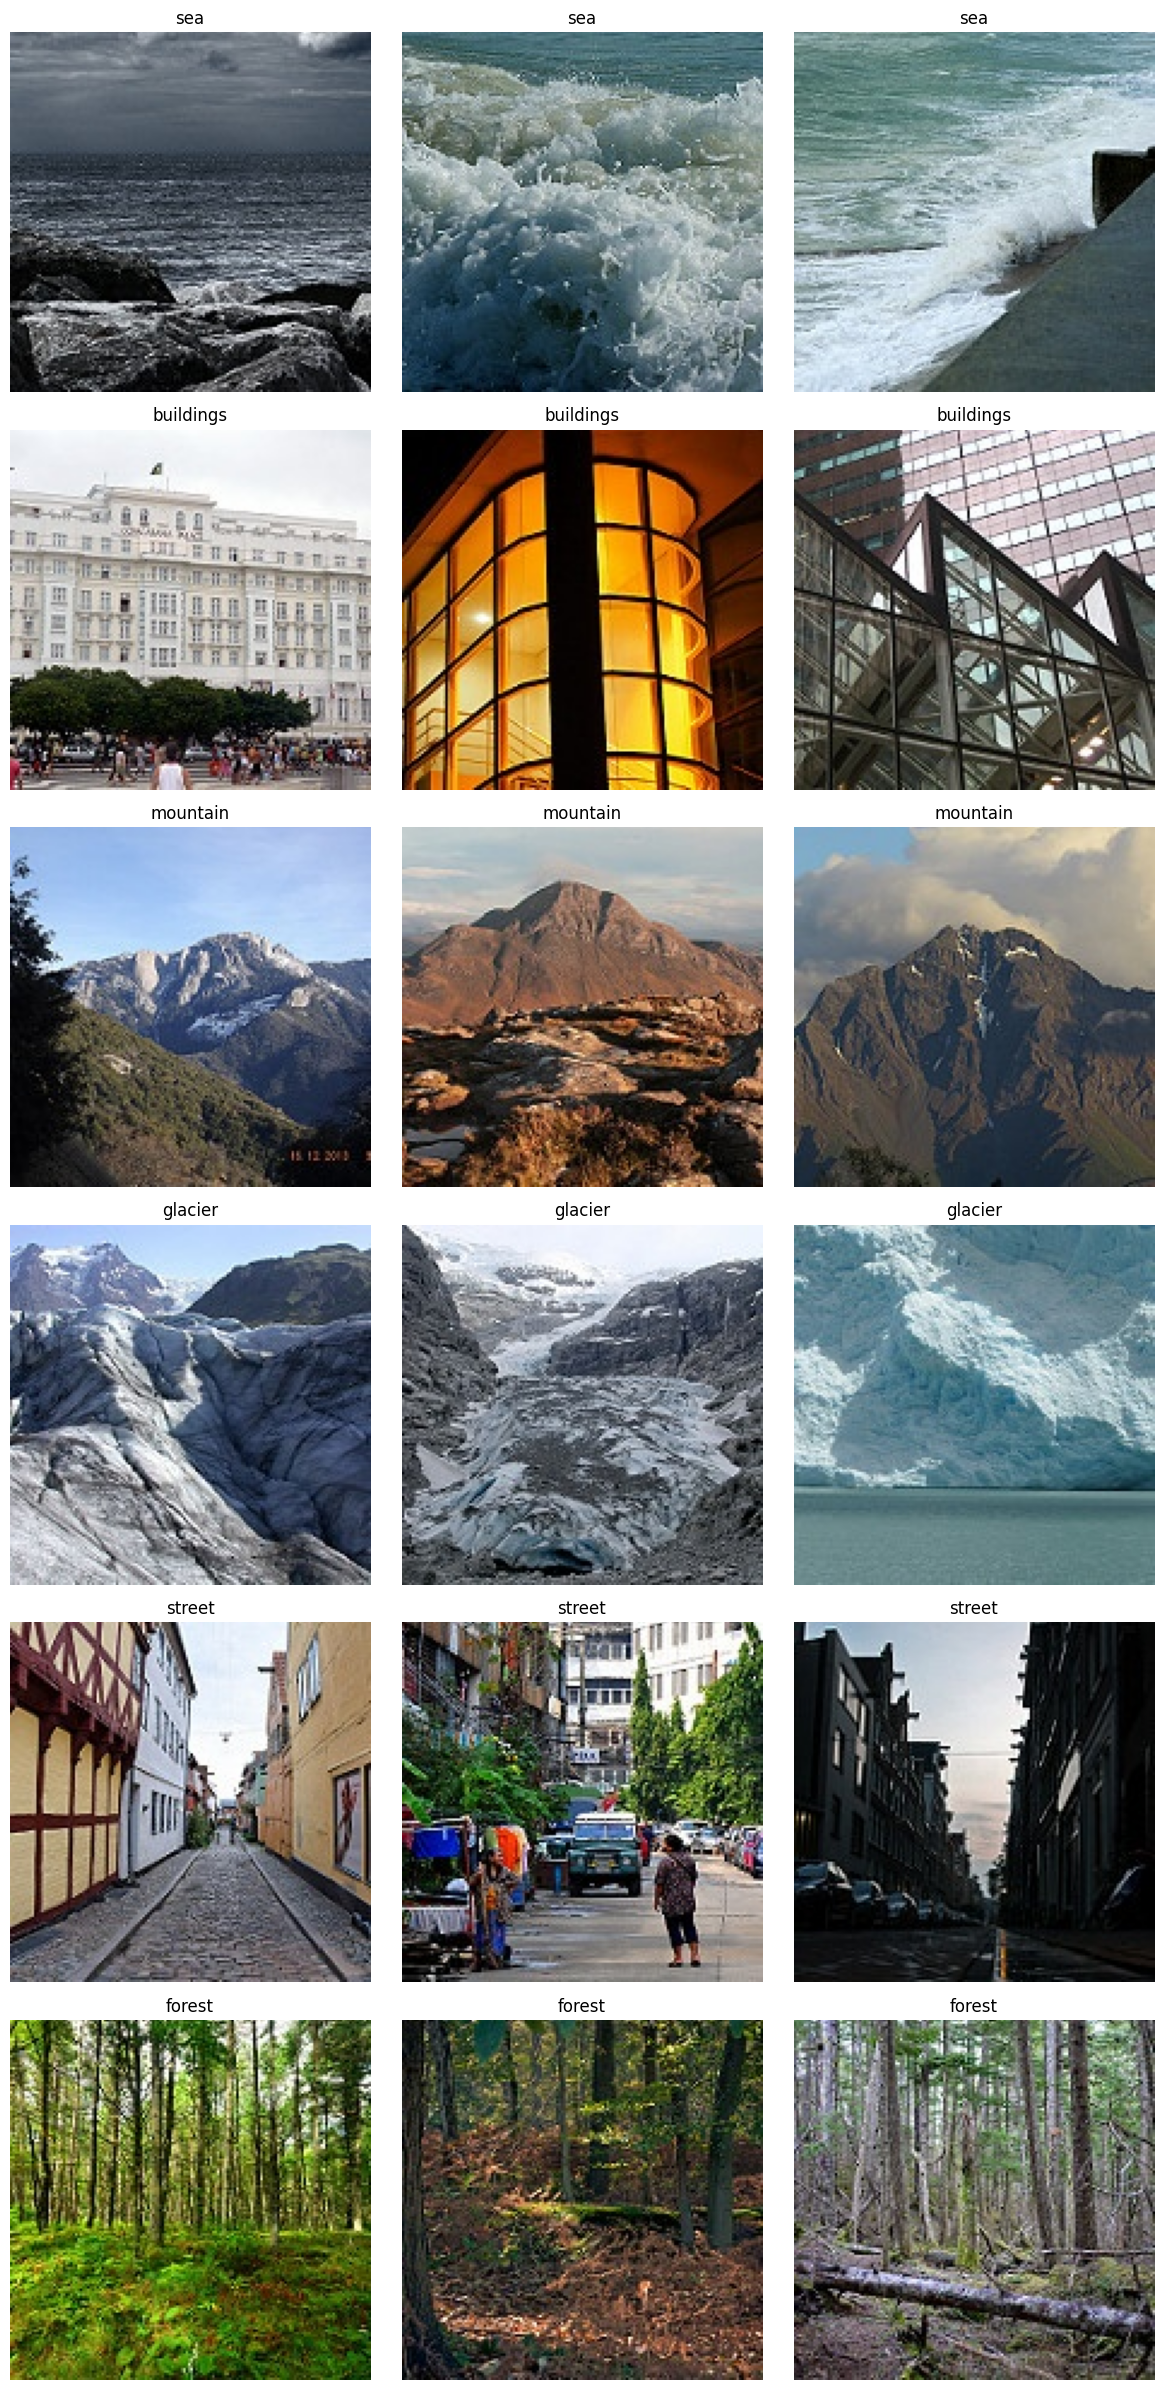

In [ ]:
from PIL import Image

def display_sample_images(base_dir, num_samples=3):
    classes = os.listdir(base_dir)
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(12, len(classes) * 4))

    if len(classes) == 1:
        axes = [axes]

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(base_dir, class_name)
        if os.path.isdir(class_dir) and not class_name.startswith('.'):
            image_files = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png'))]
            sample_images = random.sample(image_files, num_samples)

            for j, image_file in enumerate(sample_images):
                image_path = os.path.join(class_dir, image_file)
                image = Image.open(image_path)
                image = image.convert('RGB')
                axes[i][j].imshow(image)
                axes[i][j].axis('off')
                axes[i][j].set_title(class_name)

    plt.tight_layout()
    plt.show()

train_base_dir = '/content/intel_data/train'
display_sample_images(train_base_dir, num_samples=3)

## Budowa pierwszego modelu
### Przygotowanie danych
Zastosowano generator danych, który automatycznie odczytuje obrazy z odpowiednich folderów i przekształca je na odpowiedni format wymagany przez sieć neuronową. W zbiorze treningowym dodatkowo wprowadzono augmentację danych, stosując losowe obroty, przesunięcia i odbicia obrazów, co ma na celu zwiększenie różnorodności przykładów treningowych i poprawę zdolności generalizacji modelu. Zbiór walidacyjny został przeskalowany, ale nie poddano go augmentacji, aby odzwierciedlał rzeczywistą wydajność modelu na niezmodyfikowanych danych.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/intel_data/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/intel_data/val',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


### Model CNN
Zbudowano prostą, sekwencyjną sieć konwolucyjną przeznaczoną do klasyfikacji obrazów na sześć kategorii. Architektura składa się z trzech bloków konwolucyjnych, każdy zakończony normalizacją i warstwą spłaszczającą dane przestrzenne poprzez pooling. Zastosowano także dropout w celu ograniczenia przeuczenia. Ostateczna warstwa wyjściowa wykorzystuje funkcję `softmax`, odpowiednią dla klasyfikacji wieloklasowej. Model został skompilowany z użyciem funkcji straty `categorical_crossentropy`, optymalizatora `adam` oraz metryki `accuracy`.

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # 6 klas
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,830,022 (18.43 MB)

 Trainable params: 4,829,574 (18.42 MB)

 Non-trainable params: 448 (1.75 KB)

Zastosowano `early stopping`, który przerwie trening, jeśli model przestanie poprawiać się na zbiorze walidacyjnym, minimalizując ryzyko przeuczenia. Dodatkowo `model checkpoint` pozwala na zapisanie wersji modelu, która osiągnęła najlepsze wyniki walidacyjne, co umożliwia późniejsze użycie najbardziej efektywnego wariantu. Model trenowany jest przez maksymalnie 30 epok na przygotowanych wcześniej zbiorach danych.

In [ ]:
model_path = 'models/cnn_v1.keras'

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(model_path, save_best_only=True)
]

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 82s 208ms/step - accuracy: 0.3469 - loss: 3.3995 - val_accuracy: 0.3374 - val_loss: 3.2632
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 66s 187ms/step - accuracy: 0.4069 - loss: 1.5098 - val_accuracy: 0.5178 - val_loss: 1.6855
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 65s 186ms/step - accuracy: 0.4630 - loss: 1.3269 - val_accuracy: 0.5439 - val_loss: 1.4562
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 66s 187ms/step - accuracy: 0.4705 - loss: 1.3327 - val_accuracy: 0.4497 - val_loss: 1.4477
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 65s 185ms/step - accuracy: 0.5100 - loss: 1.2096 - val_accuracy: 0.5596 - val_loss: 1.1243
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 66s 188ms/step - accuracy: 0.5278 - loss: 1.1881 - val_accuracy: 0.6277 - val_loss: 1.0562
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 65s 184ms/step - accuracy: 0.5411 - loss: 1.1452 - val_accuracy: 0.6822 - val_loss: 1.0860
Epoch 8/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 65s 185ms/step - accuracy: 0.5577 - loss: 1

### Wyniki podstawowego modelu

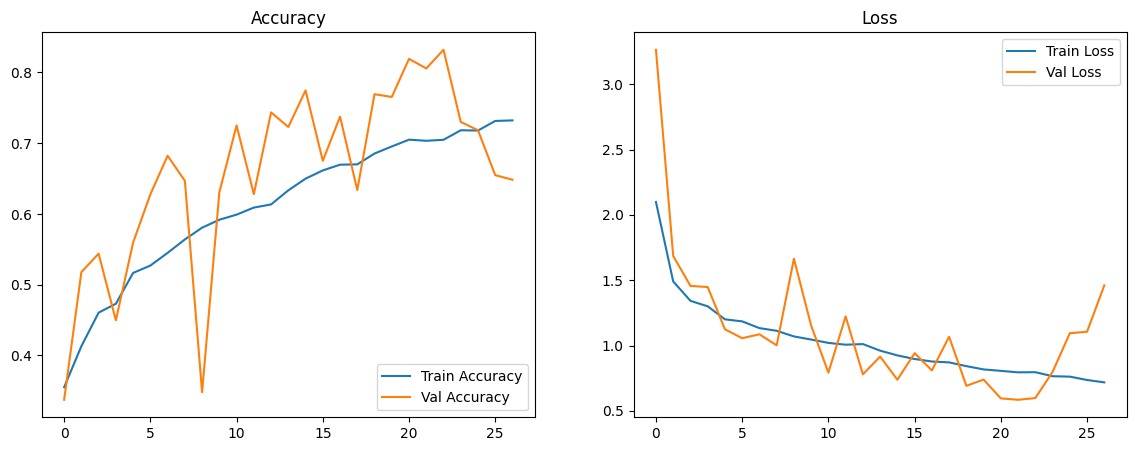

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')

    plt.show()

plot_history(history)

Wyniki trenowania modelu pokazują, że dokładność na zbiorze treningowym systematycznie rośnie, co sugeruje, że model uczy się rozpoznawać wzorce w danych. Na zbiorze walidacyjnym dokładność wykazuje większe wahania, co może wskazywać na pewną niestabilność w procesie uczenia lub na większą trudność danych walidacyjnych.

Strata na zbiorze treningowym maleje w sposób ciągły, natomiast na zbiorze walidacyjnym po początkowej poprawie zaczyna wykazywać pewne skoki, a pod koniec rośnie, co sugeruje, że model zaczyna się przeuczać. Early stopping zatrzymał trening w odpowiednim momencie, zanim przeuczenie stało się zbyt wyraźne. Ogólnie model osiąga rozsądne wyniki, jednak istnieje przestrzeń do dalszej poprawy stabilności i generalizacji.

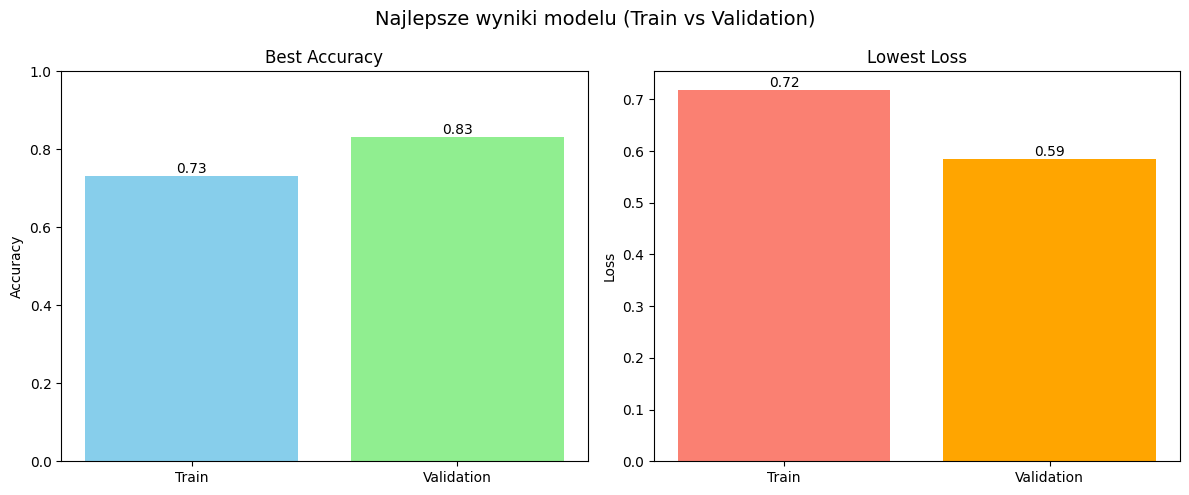

In [ ]:
best_train_acc = max(history.history['accuracy'])
best_val_acc = max(history.history['val_accuracy'])

lowest_train_loss = min(history.history['loss'])
lowest_val_loss = min(history.history['val_loss'])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].bar(['Train', 'Validation'], [best_train_acc, best_val_acc], color=['skyblue', 'lightgreen'])
axs[0].set_title('Best Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim(0, 1)
axs[0].bar_label(axs[0].containers[0], fmt='%.2f')

axs[1].bar(['Train', 'Validation'], [lowest_train_loss, lowest_val_loss], color=['salmon', 'orange'])
axs[1].set_title('Lowest Loss')
axs[1].set_ylabel('Loss')
axs[1].bar_label(axs[1].containers[0], fmt='%.2f')

plt.suptitle('Najlepsze wyniki modelu (Train vs Validation)', fontsize=14)
plt.tight_layout()
plt.show()

88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step


<Figure size 800x600 with 0 Axes>

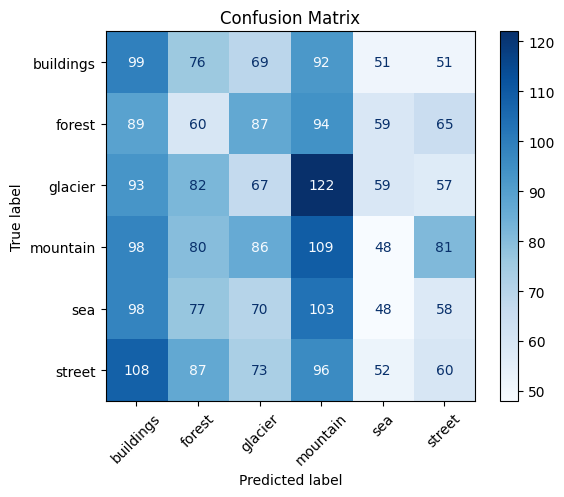

In [ ]:
class_labels = list(train_generator.class_indices.keys())

val_generator.reset()
preds = model.predict(val_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(8, 6))
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

### Optymalizacja modelu
Proces optymalizacji rozpoczęto poprzez automatyczne przeszukiwanie przestrzeni hiperparametrów oraz dodatkowe zabezpieczenia w trakcie treningu. Zdefiniowano funkcję budującą model, która pozwala elastycznie zmieniać liczbę warstw konwolucyjnych, liczbę filtrów, użycie batch normalization, poziom dropout oraz tempo uczenia, co umożliwia eksperymentowanie z różnymi konfiguracjami architektury.

Dodano także własny callback, który przerywa trening, jeśli bieżąca dokładność walidacyjna znacząco spadnie względem najlepszej dotychczas osiągniętej wartości. Takie podejście ogranicza marnowanie czasu na trenowanie modeli o słabej skuteczności. W ramach każdego eksperymentu zapisywana jest maksymalna osiągnięta dokładność walidacyjna, a po zakończeniu treningu ocenia się model przy użyciu miary f1, aby uwzględnić także jakość klasyfikacji w przypadku nierównomiernego rozkładu klas.

In [ ]:
class EarlyTerminateOnLowValAccuracy(Callback):
    def __init__(self, best_val_acc_so_far, threshold_diff=0.1, min_epochs=2):
        super().__init__()
        self.best_val_acc_so_far = best_val_acc_so_far
        self.threshold_diff = threshold_diff
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        if epoch + 1 < self.min_epochs:
            return
        current_val_acc = logs.get('val_accuracy')
        if current_val_acc is not None and current_val_acc < self.best_val_acc_so_far - self.threshold_diff:
            print(f"\nPrzerywanie — val_accuracy {current_val_acc:.4f} << {self.best_val_acc_so_far:.4f}")
            self.model.stop_training = True


def build_cnn_model(conv_layers=3, filters=32, dropout_rate=0.5, learning_rate=0.001, use_batchnorm=True):
    model = Sequential()
    for i in range(conv_layers):
        if i == 0:
            model.add(Conv2D(filters, (3, 3), activation='relu', input_shape=(150, 150, 3),
                             kernel_initializer='he_normal'))
        else:
            model.add(Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal'))

        if use_batchnorm:
            model.add(BatchNormalization())

        model.add(MaxPooling2D(2, 2))
        filters = min(filters * 2, 256)

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(6, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model


def search_best_model(train_generator, val_generator, param_grid):
    best_model = None
    best_f1_score = -np.inf
    best_val_accuracy = -np.inf
    best_params = {}

    for params in ParameterGrid(param_grid):
        print(f"\nTrening z parametrami: {params}")

        model = build_cnn_model(**params)

        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
        early_prune = EarlyTerminateOnLowValAccuracy(best_val_accuracy, threshold_diff=0.1, min_epochs=4)

        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=10,
            callbacks=[early_stop, early_prune],
            verbose=1
        )

        current_val_acc = max(history.history['val_accuracy'])
        print(f"Val accuracy: {current_val_acc:.4f}")

        if current_val_acc < best_val_accuracy - 0.1:
            print("Pomijanie modelu")
            continue

        val_pred = model.predict(val_generator)
        val_pred = np.argmax(val_pred, axis=1)
        val_labels = val_generator.labels
        f1 = f1_score(val_labels, val_pred, average='weighted')
        print(f"F1-score: {f1:.4f}")

        if f1 > best_f1_score:
            print("Nowy najlepszy model")
            best_f1_score = f1
            best_val_accuracy = current_val_acc
            best_model = model
            best_params = params

    print(f"\nNajlepszy F1: {best_f1_score:.4f} | val_acc: {best_val_accuracy:.4f}")
    print(f"Parametry: {best_params}")
    return best_model, best_params

Przygotowano siatkę parametrów, w której zdefiniowano różne kombinacje liczby warstw konwolucyjnych, liczby filtrów, poziomu dropout i tempa uczenia. Przyjęto, że batch normalization będzie stosowane we wszystkich konfiguracjach. Funkcja `search_best_model` została uruchomiona w celu automatycznego przetestowania wszystkich kombinacji tych parametrów, aby znaleźć model o najlepszym wyniku f1 na zbiorze walidacyjnym.

Po zakończeniu procesu najlepszy znaleziony model został zapisany.

In [ ]:
param_grid = {
    'conv_layers': [2, 3],
    'filters': [16, 32],
    'dropout_rate': [0.3, 0.5],
    'learning_rate': [0.0005, 0.001],
    'use_batchnorm': [True]
}

best_model, best_params = search_best_model(train_generator, val_generator, param_grid)
best_model.save('models/cnn_v2.keras')


Trening z parametrami: {'conv_layers': 2, 'dropout_rate': 0.3, 'filters': 16, 'learning_rate': 0.0005, 'use_batchnorm': True}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 72s 190ms/step - accuracy: 0.4315 - loss: 2.8210 - val_accuracy: 0.5460 - val_loss: 1.9235
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 80s 190ms/step - accuracy: 0.5472 - loss: 1.2187 - val_accuracy: 0.6623 - val_loss: 0.9682
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 64s 182ms/step - accuracy: 0.5800 - loss: 1.1173 - val_accuracy: 0.6284 - val_loss: 1.0091
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 65s 184ms/step - accuracy: 0.6118 - loss: 1.0258 - val_accuracy: 0.7093 - val_loss: 0.8128
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 65s 185ms/step - accuracy: 0.6562 - loss: 0.9250 - val_accuracy: 0.7290 - val_loss: 0.8338
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 65s 185ms/step - accuracy: 0.6794 - loss: 0.8662 - val_accuracy: 0.7718 - val_loss: 0.7359
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 65s 186ms/step - accuracy: 0.6873 - loss: 0.8642 - val_accuracy: 0.7653 - val_loss: 0.7346
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 65s 186ms/step - accuracy: 0.7109 - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 73s 196ms/step - accuracy: 0.4117 - loss: 3.6490 - val_accuracy: 0.5977 - val_loss: 1.3605
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 66s 188ms/step - accuracy: 0.5147 - loss: 1.2417 - val_accuracy: 0.5218 - val_loss: 1.2270
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 65s 186ms/step - accuracy: 0.5440 - loss: 1.1488 - val_accuracy: 0.6530 - val_loss: 0.9500
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.5536 - loss: 1.1410
Przerywanie — val_accuracy 0.6073 << 0.7871
351/351 ━━━━━━━━━━━━━━━━━━━━ 66s 189ms/step - accuracy: 0.5536 - loss: 1.1409 - val_accuracy: 0.6073 - val_loss: 1.2957
Restoring model weights from the end of the best epoch: 3.
Val accuracy: 0.6530
Pomijanie modelu

Trening z parametrami: {'conv_layers': 2, 'dropout_rate': 0.3, 'filters': 32, 'learning_rate': 0.0005, 'use_batchnorm': True}
Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 74s 200ms/step - accuracy: 0.4288 - loss: 3.8365 - val_accuracy: 0.5713 - val_loss: 1.5537


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 73s 196ms/step - accuracy: 0.4149 - loss: 6.4927 - val_accuracy: 0.4879 - val_loss: 2.5843
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 67s 190ms/step - accuracy: 0.4305 - loss: 1.5722 - val_accuracy: 0.5966 - val_loss: 1.3639
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 66s 188ms/step - accuracy: 0.4575 - loss: 1.3798 - val_accuracy: 0.6184 - val_loss: 1.1039
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.4936 - loss: 1.2887
Przerywanie — val_accuracy 0.5264 << 0.7871
351/351 ━━━━━━━━━━━━━━━━━━━━ 68s 194ms/step - accuracy: 0.4936 - loss: 1.2887 - val_accuracy: 0.5264 - val_loss: 1.3013
Restoring model weights from the end of the best epoch: 3.
Val accuracy: 0.6184
Pomijanie modelu

Trening z parametrami: {'conv_layers': 2, 'dropout_rate': 0.5, 'filters': 16, 'learning_rate': 0.0005, 'use_batchnorm': True}
Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 74s 200ms/step - accuracy: 0.3879 - loss: 2.7370 - val_accuracy: 0.5863 - val_loss: 1.2353


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 75s 201ms/step - accuracy: 0.4570 - loss: 2.5634 - val_accuracy: 0.6031 - val_loss: 1.1251
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 66s 188ms/step - accuracy: 0.5999 - loss: 1.0444 - val_accuracy: 0.6569 - val_loss: 0.9054
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 67s 191ms/step - accuracy: 0.6428 - loss: 0.9584 - val_accuracy: 0.7479 - val_loss: 0.6932
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 65s 185ms/step - accuracy: 0.6796 - loss: 0.8677 - val_accuracy: 0.7803 - val_loss: 0.6420
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.7026 - loss: 0.8041
Przerywanie — val_accuracy 0.6569 << 0.7871
351/351 ━━━━━━━━━━━━━━━━━━━━ 64s 182ms/step - accuracy: 0.7026 - loss: 0.8041 - val_accuracy: 0.6569 - val_loss: 1.0496
Restoring model weights from the end of the best epoch: 4.
Val accuracy: 0.7803
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step
F1-score: 0.1646

Trening z parametrami: {'conv_layers': 3, 'dropout_rate': 0.3, 'filters': 32, 'learnin

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 76s 201ms/step - accuracy: 0.4512 - loss: 2.0592 - val_accuracy: 0.6295 - val_loss: 1.0126
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 66s 189ms/step - accuracy: 0.5817 - loss: 1.0832 - val_accuracy: 0.7193 - val_loss: 0.8004
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - accuracy: 0.6307 - loss: 1.0034 - val_accuracy: 0.7486 - val_loss: 0.7045
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 67s 191ms/step - accuracy: 0.6772 - loss: 0.8871 - val_accuracy: 0.7029 - val_loss: 0.8792
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - accuracy: 0.6985 - loss: 0.8276 - val_accuracy: 0.7514 - val_loss: 0.7033
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 72s 206ms/step - accuracy: 0.7141 - loss: 0.7842 - val_accuracy: 0.7817 - val_loss: 0.6162
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - accuracy: 0.7421 - loss: 0.7195 - val_accuracy: 0.7721 - val_loss: 0.6410
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 196ms/step - accuracy: 0.7541 - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 76s 202ms/step - accuracy: 0.4509 - loss: 3.0481 - val_accuracy: 0.5157 - val_loss: 1.6185
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 196ms/step - accuracy: 0.5796 - loss: 1.1206 - val_accuracy: 0.7111 - val_loss: 0.8378
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - accuracy: 0.6403 - loss: 0.9958 - val_accuracy: 0.6869 - val_loss: 0.8885
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.6621 - loss: 0.9224
Przerywanie — val_accuracy 0.6576 << 0.7871
351/351 ━━━━━━━━━━━━━━━━━━━━ 71s 201ms/step - accuracy: 0.6622 - loss: 0.9223 - val_accuracy: 0.6576 - val_loss: 0.9356
Restoring model weights from the end of the best epoch: 2.
Val accuracy: 0.7111
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step
F1-score: 0.1554

Trening z parametrami: {'conv_layers': 3, 'dropout_rate': 0.5, 'filters': 16, 'learning_rate': 0.0005, 'use_batchnorm': True}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 79s 206ms/step - accuracy: 0.4334 - loss: 1.9630 - val_accuracy: 0.5296 - val_loss: 1.4654
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 68s 195ms/step - accuracy: 0.5710 - loss: 1.1339 - val_accuracy: 0.6979 - val_loss: 0.8622
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - accuracy: 0.6052 - loss: 1.0342 - val_accuracy: 0.7372 - val_loss: 0.7490
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 66s 188ms/step - accuracy: 0.6405 - loss: 0.9835 - val_accuracy: 0.7603 - val_loss: 0.6731
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 67s 192ms/step - accuracy: 0.6582 - loss: 0.9086 - val_accuracy: 0.7953 - val_loss: 0.6403
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 66s 189ms/step - accuracy: 0.6616 - loss: 0.8886 - val_accuracy: 0.7479 - val_loss: 0.7885
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 198ms/step - accuracy: 0.6768 - loss: 0.8599 - val_accuracy: 0.8074 - val_loss: 0.5792
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 67s 191ms/step - accuracy: 0.7167 - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 76s 201ms/step - accuracy: 0.4179 - loss: 2.3339 - val_accuracy: 0.5385 - val_loss: 1.3396
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - accuracy: 0.5198 - loss: 1.2543 - val_accuracy: 0.6262 - val_loss: 1.1330
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - accuracy: 0.5307 - loss: 1.2044 - val_accuracy: 0.6312 - val_loss: 0.9334
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.5797 - loss: 1.0667
Przerywanie — val_accuracy 0.6213 << 0.8142
351/351 ━━━━━━━━━━━━━━━━━━━━ 72s 205ms/step - accuracy: 0.5797 - loss: 1.0668 - val_accuracy: 0.6213 - val_loss: 0.9689
Restoring model weights from the end of the best epoch: 3.
Val accuracy: 0.6312
Pomijanie modelu

Trening z parametrami: {'conv_layers': 3, 'dropout_rate': 0.5, 'filters': 32, 'learning_rate': 0.0005, 'use_batchnorm': True}
Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 207ms/step - accuracy: 0.3929 - loss: 2.2291 - val_accuracy: 0.4672 - val_loss: 1.7659


88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8199 - loss: 0.5335
Validation Loss: 0.5309
Validation Accuracy: 0.8142


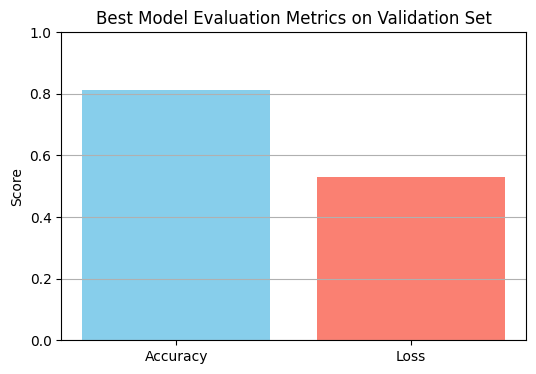

88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step


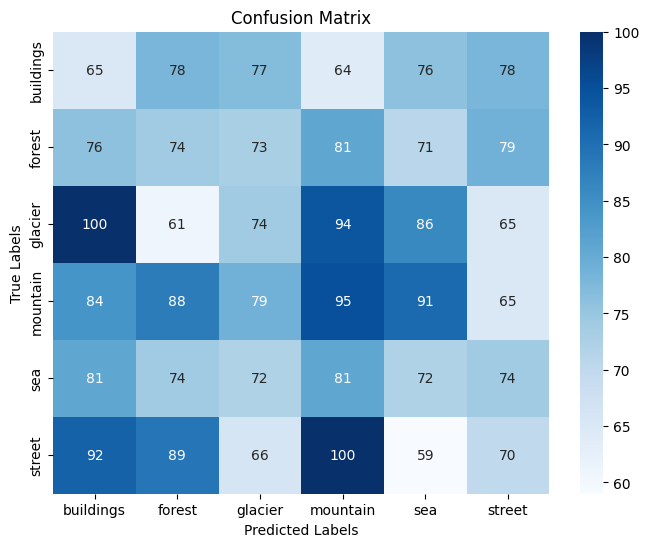

In [ ]:
model = load_model('models/cnn_v2.keras')

loss, accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

plt.figure(figsize=(6, 4))
plt.bar(['Accuracy', 'Loss'], [accuracy, loss], color=['skyblue', 'salmon'])
plt.title("Best Model Evaluation Metrics on Validation Set")
plt.ylim(0, 1)
plt.ylabel('Score')
plt.grid(axis='y')
plt.show()

y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.labels

class_names = list(val_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Po przeprowadzonej optymalizacji model osiągnął nieznaczną poprawę w porównaniu do wcześniejszej wersji. Uzyskana dokładność walidacyjna na poziomie około 81% oraz strata wynosząca 0,53 świadczą o nieco lepszym dopasowaniu do danych i większej stabilności działania.

Macierz pomyłek pokazuje jednak, że nadal występują błędy klasyfikacji.

### Zoptymalizowana architektura
W tym etapie stworzono bardziej rozbudowaną architekturę sieci konwolucyjnej, uwzględniającą dodatkowe warstwy dense oraz dropout, co miało na celu zwiększenie zdolności modelu do reprezentowania bardziej złożonych zależności w danych przy jednoczesnej ochronie przed przeuczeniem.

Zastosowano bardziej zaawansowaną augmentację danych, wzbogacając treningowy zbiór o dodatkowe warianty obrazów poprzez losowe przesunięcia, obroty, zmiany skali oraz odbicia poziome. Wprowadzono także obliczanie wag klas, aby uwzględnić ewentualne niezbalansowanie danych i dać większe znaczenie rzadziej występującym klasom.

Proces uczenia został wsparty przez callbacki `early stopping` oraz `reduce learning rate`. Pierwszy monitoruje stratę walidacyjną i przerywa trening przy braku poprawy, natomiast drugi dynamicznie zmniejsza tempo uczenia w przypadku zatrzymania postępów, co pozwala lepiej dopasować model w późniejszych etapach treningu.

In [ ]:
def build_optimized_cnn(conv_layers=3, filters=16, dropout_rate=0.5, learning_rate=0.0005, use_batchnorm=True):
    model = Sequential()
    for i in range(conv_layers):
        model.add(Conv2D(filters, (3, 3), activation='relu', input_shape=(150, 150, 3) if i == 0 else None,
                         kernel_initializer='he_normal', padding='same'))
        if use_batchnorm:
            model.add(BatchNormalization())
        model.add(MaxPooling2D(2, 2))
        filters = min(filters * 2, 256)

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(6, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model


def compute_class_weights(generator):
    class_indices = generator.class_indices
    labels = generator.labels
    weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    return dict(zip(np.unique(labels), weights))


train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator_aug = train_datagen_augmented.flow_from_directory(
    '/content/intel_data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/intel_data/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

weights = compute_class_weights(train_generator_aug)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

model_v3 = build_optimized_cnn()

history = model_v3.fit(
    train_generator_aug,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, reduce_lr],
    class_weight=weights,
    verbose=1
)

model_v3.save('models/cnn_v3.keras')

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 215ms/step - accuracy: 0.3436 - loss: 2.9782 - val_accuracy: 0.5531 - val_loss: 1.2475 - learning_rate: 5.0000e-04
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 68s 194ms/step - accuracy: 0.4173 - loss: 1.4717 - val_accuracy: 0.5849 - val_loss: 1.2484 - learning_rate: 5.0000e-04
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 67s 192ms/step - accuracy: 0.4673 - loss: 1.3981 - val_accuracy: 0.6034 - val_loss: 1.1150 - learning_rate: 5.0000e-04
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - accuracy: 0.4999 - loss: 1.3000 - val_accuracy: 0.6637 - val_loss: 1.0488 - learning_rate: 5.0000e-04
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - accuracy: 0.5596 - loss: 1.2004 - val_accuracy: 0.6887 - val_loss: 0.9730 - learning_rate: 5.0000e-04
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 66s 188ms/step - accuracy: 0.5964 - loss: 1.0856 - val_accuracy: 0.6815 - val_loss: 1.0135 - learning_rate: 5.0000e-04
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 68s 19

88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
Classification report:
              precision    recall  f1-score   support

   buildings       0.74      0.84      0.79       438
      forest       0.90      0.98      0.94       454
     glacier       0.85      0.76      0.80       480
    mountain       0.86      0.72      0.78       502
         sea       0.76      0.89      0.82       454
      street       0.87      0.81      0.84       476

    accuracy                           0.83      2804
   macro avg       0.83      0.83      0.83      2804
weighted avg       0.83      0.83      0.83      2804

Weighted F1-score: 0.8284


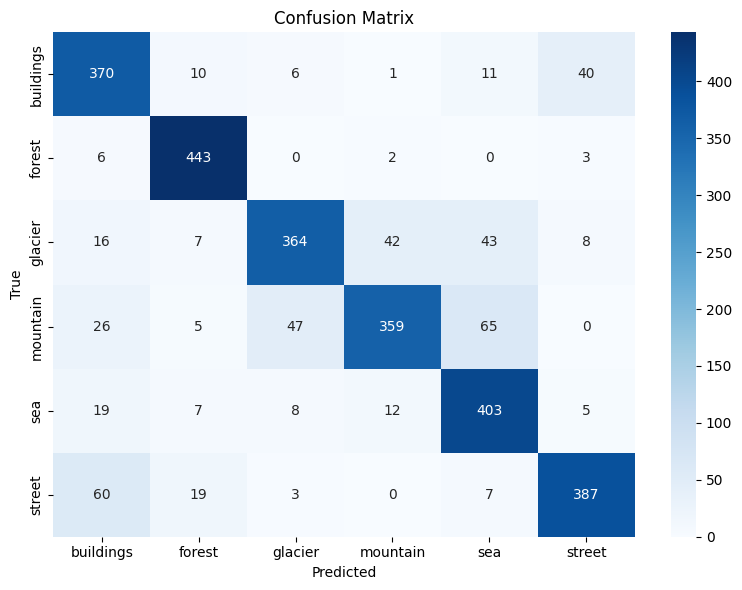

In [ ]:
model = load_model('models/cnn_v3.keras')

pred_probs = model.predict(val_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Weighted F1-score: {f1:.4f}")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

Osiągnięte wyniki potwierdzają wyraźną poprawę jakości klasyfikacji po wprowadzeniu bardziej rozbudowanej architektury i zaawansowanych technik uczenia. Model uzyskał dokładność na poziomie około 83% oraz weighted f1-score równy 0.8284, co oznacza, że jest dobrze zbalansowany pod względem precyzji i czułości.

Macierz pomyłek pokazuje, że model bardzo skutecznie klasyfikuje kategorie takie jak forest czy sea, osiągając wysokie wskaźniki poprawnych predykcji. Problemy pojawiają się głównie przy rozróżnianiu `glacier` i `mountain` oraz `buildings` i `street`, gdzie nadal występuje sporo błędów klasyfikacji między tymi klasami, co jest zrozumiałe ze względu na ich podobieństwo wizualne.

Raport klasyfikacji wskazuje na wysoką precyzję i recall we wszystkich klasach, przy czym najlepsze wyniki osiągnięto dla kategorii `forest`. Klasa mountain wykazuje nieco niższy recall, co sugeruje, że model czasami myli góry z innymi krajobrazami.

### Fine tuning modelu
W tej części przeprowadzono proces dalszego dostrajania najlepszego modelu, aby jeszcze lepiej dopasować go do danych. Wczytano wcześniej zapisany model i ustawiono, że tylko ostatnie warstwy konwolucyjne będą trenowalne, podczas gdy wcześniejsze warstwy pozostaną zamrożone.

Zmieniono optymalizator na `SGD` z niskim tempem uczenia i włączonym momentum oraz nesterovem, co pozwala na bardziej stabilne i precyzyjne dostrajanie wag. Proces treningu wsparto callbackami kontrolującymi przebieg uczenia.

Cały zabieg miał na celu delikatne poprawienie wyników bez nadmiernego ryzyka przeuczenia, wykorzystując już wytrenowane cechy modelu i lepsze dostosowanie do specyfiki dostępnego zbioru danych.

In [ ]:
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator_aug = train_datagen_augmented.flow_from_directory(
    '/content/intel_data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/intel_data/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

model = load_model('models/cnn_v3.keras')

# odmrozenie tylko ostatnich 2
trainable = False
for layer in reversed(model.layers):
    if isinstance(layer, Conv2D):
        if not trainable:
            trainable = True
        layer.trainable = trainable
    else:
        layer.trainable = trainable

model.compile(
    optimizer=SGD(learning_rate=1e-5, momentum=0.9, nesterov=True),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint('models/cnn_v4_finetuned.keras', save_best_only=True)
]

history = model.fit(
    train_generator_aug,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 73s 199ms/step - accuracy: 0.8119 - loss: 0.5662 - val_accuracy: 0.8295 - val_loss: 0.4978 - learning_rate: 1.0000e-05
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 64s 184ms/step - accuracy: 0.8129 - loss: 0.5514 - val_accuracy: 0.8313 - val_loss: 0.4903 - learning_rate: 1.0000e-05
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 65s 184ms/step - accuracy: 0.8093 - loss: 0.5578 - val_accuracy: 0.8359 - val_loss: 0.4914 - learning_rate: 1.0000e-05
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 64s 184ms/step - accuracy: 0.8220 - loss: 0.5441 - val_accuracy: 0.8192 - val_loss: 0.5156 - learning_rate: 1.0000e-05
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8127 - loss: 0.5631
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
351/351 ━━━━━━━━━━━━━━━━━━━━ 64s 181ms/step - accuracy: 0.8127 - loss: 0.5631 - val_accuracy: 0.8335 - val_loss: 0.

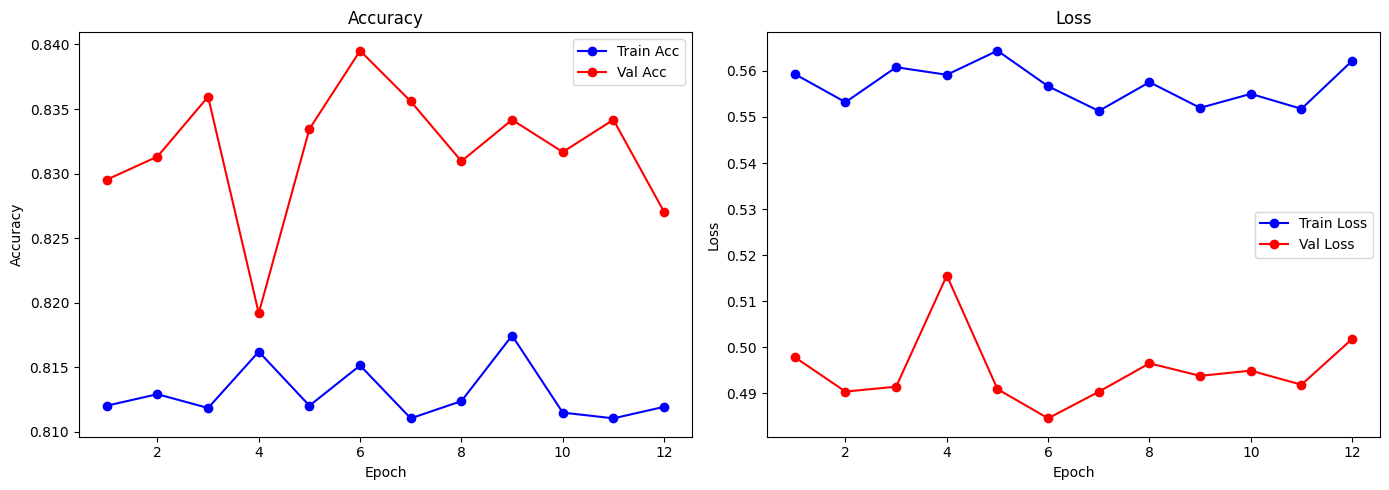

In [ ]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Train Acc')
    plt.plot(epochs, val_acc, 'ro-', label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Train Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

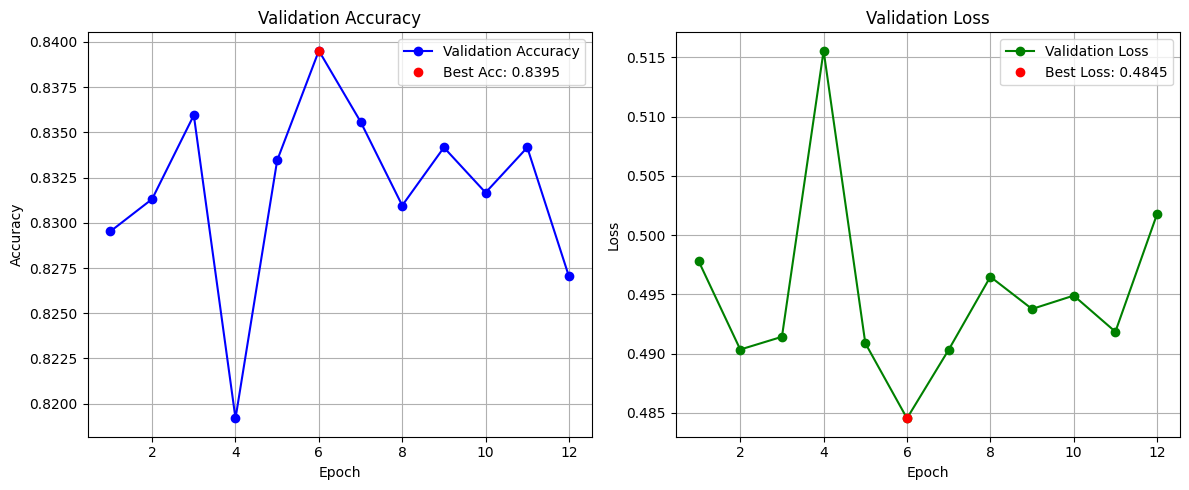

In [ ]:
acc = history.history['val_accuracy']
loss = history.history['val_loss']
epochs = np.arange(1, len(acc) + 1)

best_acc = max(acc)
best_acc_epoch = epochs[np.argmax(acc)]

best_loss = min(loss)
best_loss_epoch = epochs[np.argmin(loss)]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-o', label='Validation Accuracy')
plt.plot(best_acc_epoch, best_acc, 'ro', label=f'Best Acc: {best_acc:.4f}')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'g-o', label='Validation Loss')
plt.plot(best_loss_epoch, best_loss, 'ro', label=f'Best Loss: {best_loss:.4f}')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step
Weighted F1-score: 0.8383


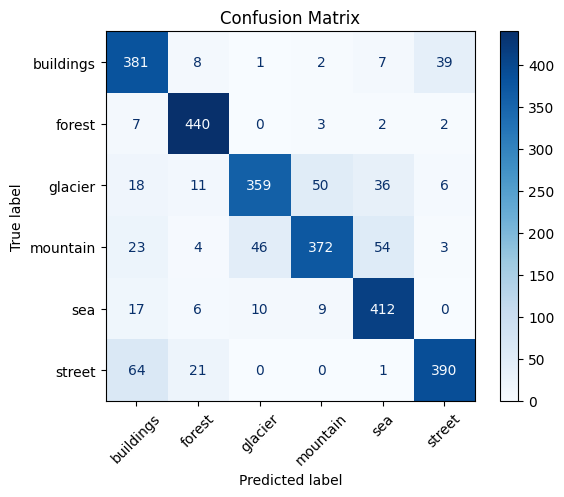

In [ ]:
val_pred = model.predict(val_generator)
val_pred_classes = np.argmax(val_pred, axis=1)
true_classes = val_generator.classes

f1 = f1_score(true_classes, val_pred_classes, average='weighted')
print(f"Weighted F1-score: {f1:.4f}")

cm = confusion_matrix(true_classes, val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

Wyniki fine tuningu pokazują, że proces dostrojenia ostatnich warstw przyniósł niewielką, ale zauważalną poprawę jakości modelu. Weighted f1-score wzrósł do 0.8383, co oznacza dalsze zwiększenie skuteczności klasyfikacji w porównaniu do wcześniejszych etapów.

Wykresy treningu wskazują na stabilne utrzymanie się dokładności i straty na zbiorze walidacyjnym, bez wyraźnych oznak przeuczenia. Różnice pomiędzy wynikami treningu a walidacji pozostają niewielkie, co świadczy o dobrej zdolności generalizacji modelu.

## Transfer models
Do budowy kolejnych modeli został wykorzystany transfer learning, co pozwala na skorzystanie z gotowych, wcześniej wytrenowanych sieci jako ekstraktorów cech. Użyte architektury — `MobileNetV2`, `EfficientNetB0` oraz `InceptionV3` — wczytywane są z wagami przetrenowanymi na zbiorze ImageNet, a ich warstwy bazowe są zamrożone, aby podczas początkowego etapu treningu uczyć jedynie nowe, dołożone warstwy klasyfikacyjne.

Do istniejącej bazy cech dodano kilka warstw gęstych, aktywacji nieliniowych i warstw dropout, aby umożliwić bardziej skuteczne dopasowanie modelu do nowego zadania klasyfikacji krajobrazów, jednocześnie minimalizując ryzyko przeuczenia.

Proces treningu ponownie opiera się na danych z rozszerzoną augmentacją, co pozwala zwiększyć różnorodność przykładów, a przebieg uczenia kontrolowany jest za pomocą callbacków `early stopping` i `model checkpoint`. Dzięki temu dla każdego modelu zachowany zostaje najlepszy wariant osiągnięty na zbiorze walidacyjnym.

In [ ]:
input_shape = (150, 150, 3)
num_classes = 6

def build_transfer_model(base_model_fn, model_name):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # zamrażamy

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='elu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator_aug = train_datagen_augmented.flow_from_directory(
    '/content/intel_data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/intel_data/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


# modele do porównania
model_names = {
    'mnv2': MobileNetV2,
    'enb0': EfficientNetB0,
    'iv3': InceptionV3
}

trained_models = {}
transfer_histories = {}

for name, model_fn in model_names.items():
    print(f"\nTrenowanie modelu: {name}")
    model = build_transfer_model(model_fn, name)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        ModelCheckpoint(f'models/transfer_{name}_v1.keras', save_best_only=True)
    ]

    history = model.fit(
        train_generator_aug,
        validation_data=val_generator,
        epochs=15,
        callbacks=callbacks,
        verbose=1
    )

    trained_models[name] = model
    transfer_histories[name] = history.history

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.

Trenowanie modelu: mnv2


<ipython-input-8-339550bc063e>:18: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 86s 219ms/step - accuracy: 0.7468 - loss: 0.7048 - val_accuracy: 0.8905 - val_loss: 0.2979
Epoch 2/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 67s 191ms/step - accuracy: 0.8519 - loss: 0.4169 - val_accuracy: 0.8919 - val_loss: 0.2902
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 67s 192ms/step - accuracy: 0.8683 - loss: 0.3527 - val_accuracy: 0.8976 - val_loss: 0.2803
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 81s 189ms/step - accuracy: 0.8774 - loss: 0.3380 - val_accuracy: 0.8991 - val_loss: 0.2650
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 71s 202ms/step - accuracy: 0.8772 - loss: 0.3219 - val_accuracy: 0.9023 - val_loss: 0.2646
Epoch 6/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 66s 189ms/step - accuracy: 0.8850 - loss: 0.3058 - val_accuracy: 0.8969 - val_loss: 0.2778
Epoch 7/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 67s 191ms/step - accuracy: 0.8890 - loss: 0.3099 - val_accuracy: 0.9005 - val_loss: 0.2793
Epoch 8/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 67s 191ms/step - accuracy: 0.8924 - loss: 0

Możemy zauważyć, że modele MobileNetV2 i InceptionV3 osiągnęły wysoką skuteczność już na tym etapie, w przeciwieństwie do modelu `EfficientNetB0`, którego wyniki są wręcz tragiczne - dlatego też od niego rozpoczniemy dalszą optymalizacje.

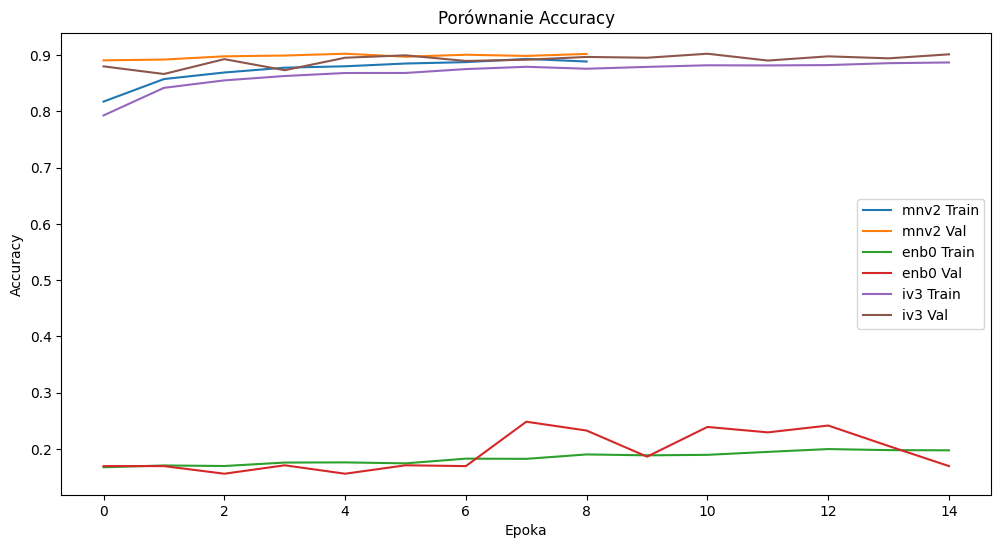

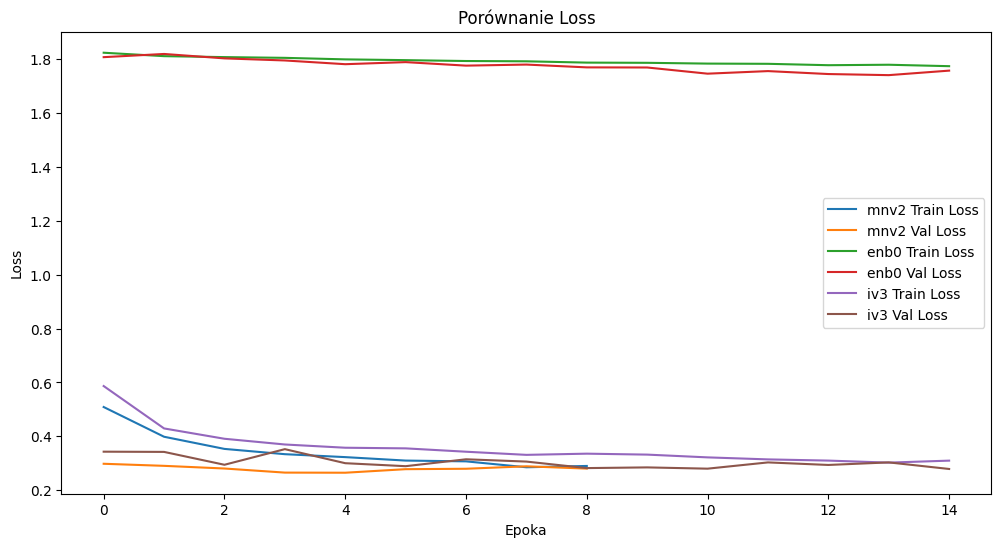

In [ ]:
plt.figure(figsize=(12, 6))
for name, hist in transfer_histories.items():
    plt.plot(hist['accuracy'], label=f'{name} Train')
    plt.plot(hist['val_accuracy'], label=f'{name} Val')
plt.title("Porównanie Accuracy")
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for name, hist in transfer_histories.items():
    plt.plot(hist['loss'], label=f'{name} Train Loss')
    plt.plot(hist['val_loss'], label=f'{name} Val Loss')
plt.title("Porównanie Loss")
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.legend()
plt.show()


==== mnv2 ====
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step
F1-score (weighted): 0.9021

Classification Report:
              precision    recall  f1-score   support

   buildings       0.91      0.93      0.92       438
      forest       0.98      0.99      0.98       454
     glacier       0.86      0.81      0.83       480
    mountain       0.82      0.85      0.84       502
         sea       0.93      0.93      0.93       454
      street       0.93      0.92      0.93       476

    accuracy                           0.90      2804
   macro avg       0.90      0.90      0.90      2804
weighted avg       0.90      0.90      0.90      2804



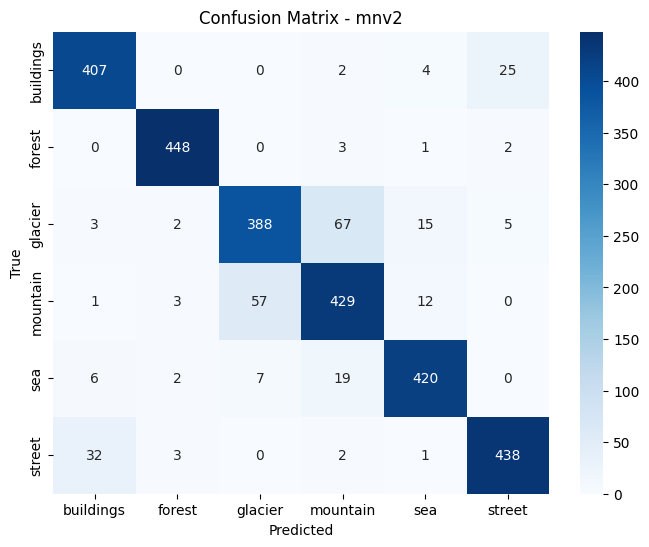


==== enb0 ====
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step
F1-score (weighted): 0.1465

Classification Report:
              precision    recall  f1-score   support

   buildings       0.00      0.00      0.00       438
      forest       0.00      0.00      0.00       454
     glacier       0.00      0.00      0.00       480
    mountain       0.37      0.65      0.47       502
         sea       0.10      0.38      0.16       454
      street       0.30      0.16      0.21       476

    accuracy                           0.21      2804
   macro avg       0.13      0.20      0.14      2804
weighted avg       0.13      0.21      0.15      2804



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


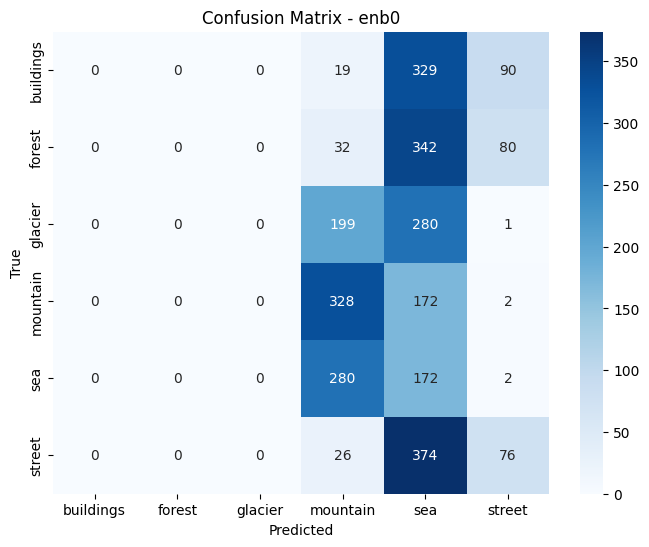


==== iv3 ====
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step
F1-score (weighted): 0.9007

Classification Report:
              precision    recall  f1-score   support

   buildings       0.92      0.90      0.91       438
      forest       0.96      0.98      0.97       454
     glacier       0.81      0.87      0.84       480
    mountain       0.90      0.79      0.84       502
         sea       0.93      0.94      0.94       454
      street       0.90      0.93      0.91       476

    accuracy                           0.90      2804
   macro avg       0.90      0.90      0.90      2804
weighted avg       0.90      0.90      0.90      2804



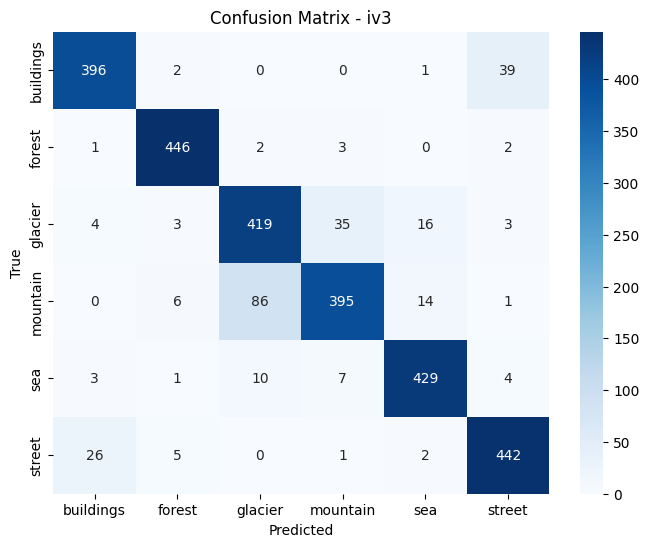

In [ ]:
for name, model in trained_models.items():
    print(f"\n==== {name} ====")
    preds = model.predict(val_generator)
    y_pred = np.argmax(preds, axis=1)
    y_true = val_generator.classes
    class_labels = list(val_generator.class_indices.keys())

    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"F1-score (weighted): {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

Wyniki modelu EfficientNetB0 pokazują, że w obecnej formie model nie nauczył się skutecznie rozróżniać poszczególnych klas. Macierz pomyłek wskazuje, że praktycznie wszystkie obrazy są błędnie klasyfikowane głównie jako sea lub mountain, niezależnie od ich rzeczywistej klasy.

Raport klasyfikacji potwierdza ten problem — dokładność wynosi zaledwie około 21%, a wartości precision, recall i f1-score dla większości klas są bliskie zeru. Model wykazuje minimalną skuteczność jedynie dla klas mountain i sea, ale nawet tam wyniki są niskie.

Taki rezultat sugeruje, że sieć nie została odpowiednio dostrojona do nowego zadania. Możliwe przyczyny to zbyt krótki czas trenowania, zbyt mała elastyczność modelu spowodowana zamrożeniem wszystkich warstw bazowych, albo konieczność dodatkowego dostosowania warstw gęstych do specyfiki danych.

### EfficientNetB0
W tej części podjęto próbę poprawy wyników modelu EfficientNetB0 poprzez pełne odmrożenie wszystkich warstw i zastosowanie pełnego fine tuningu. Dzięki temu umożliwiono dostosowanie całej architektury, a nie tylko dodanych warstw klasyfikacyjnych, do specyfiki nowego zbioru danych, co daje modelowi większą elastyczność w uczeniu się bardziej odpowiednich reprezentacji.

Użyto wyższego tempa uczenia niż w przypadku poprzedniego treningu zamrożonej sieci oraz zastosowano dynamiczne zmniejszanie learning rate w odpowiedzi na brak poprawy straty walidacyjnej, co pozwala na bardziej precyzyjne dopasowanie parametrów w kolejnych epokach.

Cała strategia treningu została wsparta mechanizmami early stopping i checkpoint, aby zatrzymać proces w optymalnym momencie i zapisać najlepszą wersję modelu.

In [ ]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

# odmrazanie wszystkich warstw
for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6, verbose=1),
    ModelCheckpoint('models/transfer_enb0_v2.keras', save_best_only=True)
]

history = model.fit(
    train_generator_aug,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 216s 388ms/step - accuracy: 0.5108 - loss: 1.4103 - val_accuracy: 0.2636 - val_loss: 1.6908 - learning_rate: 1.0000e-04
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 80s 228ms/step - accuracy: 0.8204 - loss: 0.5238 - val_accuracy: 0.5414 - val_loss: 1.6986 - learning_rate: 1.0000e-04
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8572 - loss: 0.4053
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
351/351 ━━━━━━━━━━━━━━━━━━━━ 80s 223ms/step - accuracy: 0.8572 - loss: 0.4053 - val_accuracy: 0.3442 - val_loss: 2.9933 - learning_rate: 1.0000e-04
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 222ms/step - accuracy: 0.8826 - loss: 0.3335 - val_accuracy: 0.8909 - val_loss: 0.3139 - learning_rate: 3.0000e-05
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 81s 232ms/step - accuracy: 0.8908 - loss: 0.3183 - val_accuracy: 0.8955 - val_loss: 0.3054 - learning_rate: 3.0000e-05
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 77s 219ms/

88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step

Validation Accuracy: 0.9194
Validation Loss: 0.2405

Classification Report:
              precision    recall  f1-score   support

   buildings       0.93      0.92      0.93       438
      forest       0.95      0.99      0.97       454
     glacier       0.92      0.81      0.86       480
    mountain       0.86      0.92      0.89       502
         sea       0.94      0.93      0.94       454
      street       0.92      0.94      0.93       476

    accuracy                           0.92      2804
   macro avg       0.92      0.92      0.92      2804
weighted avg       0.92      0.92      0.92      2804



<Figure size 800x600 with 0 Axes>

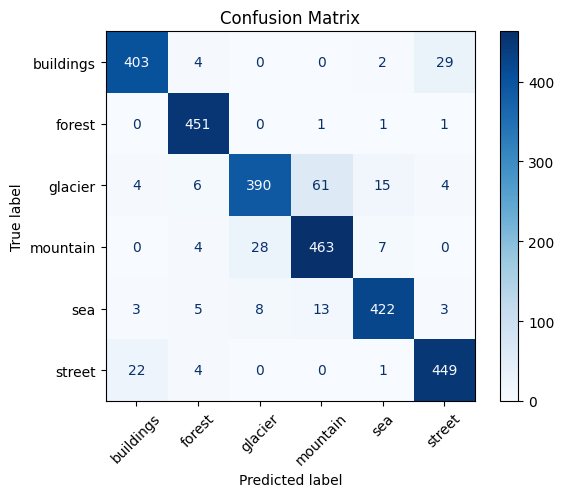

In [ ]:
model = load_model('models/transfer_enb0_v2.keras')

val_preds = model.predict(val_generator, verbose=1)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

val_loss, val_acc = model.evaluate(val_generator, verbose=0)
print(f"\nValidation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

Przeprowadzony pełny fine tuning modelu przyniósł bardzo znaczącą poprawę jakości klasyfikacji. Ostateczna dokładność walidacyjna osiągnęła poziom 91,9%, a strata spadła do 0,2405, co świadczy o bardzo dobrym dopasowaniu modelu do danych bez wyraźnych oznak przeuczenia.

Macierz pomyłek oraz raport klasyfikacji wskazują na wysoką precyzję i recall w każdej klasie. Najlepsze wyniki osiągnięto ponownie dla kategorii `forest` oraz `sea`, natomiast największe trudności nadal występują przy klasyfikacji `glacier` i `mountain`, choć nawet tam osiągnięte f1-score są wysokie.

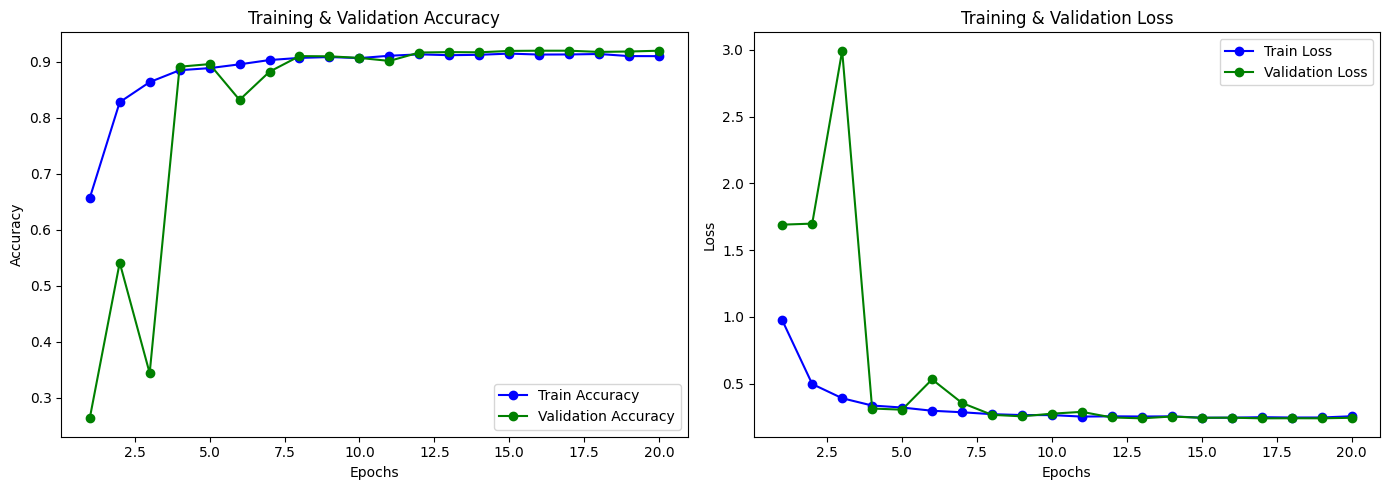

In [ ]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'go-', label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Train Loss')
    plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

Wykresy przebiegu treningu pokazują szybkie ustabilizowanie się dokładności i straty po kilku pierwszych epokach. Chociaż początkowo występowały pewne skoki strat walidacyjnych, później model osiągnął bardzo stabilne wyniki, co potwierdza skuteczność strategii stopniowego obniżania tempa uczenia.

### Fine tuning modelu
W celu sprawdzenia, czy uda się jeszcze bardziej poptrawic wyniki modelu, kontynuowano proces jego dostrajania. Wprowadzono intensywniejszą augmentację danych treningowych, obejmującą większe zakresy rotacji, przesunięć, powiększeń, ścinania i zmiany jasności, aby jeszcze bardziej zwiększyć różnorodność danych wejściowych i poprawić zdolność modelu do generalizacji.

Do już dobrze wytrenowanego modelu wprowadzono selektywne odmrożenie.

Celem tego etapu było dalsze subtelne poprawienie jakości działania modelu, zwłaszcza w najtrudniejszych przypadkach klasyfikacji, przy jednoczesnym zachowaniu wysokiej stabilności i unikania przeuczenia.

In [ ]:
# zaawansowana augmentacja
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=(0.7, 1.3)
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator_aug = train_datagen_aug.flow_from_directory(
    '/content/intel_data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/intel_data/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

model = load_model('models/transfer_enb0_v2.keras')

# odmrazanie ostatnich kilku warstw
set_trainable = False
unfreeze_count = 0
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.BatchNormalization):
        unfreeze_count += 1
        if unfreeze_count <= 20:  # ostatnie 20 warstw
            layer.trainable = True
            set_trainable = True
        else:
            break
    elif set_trainable:
        layer.trainable = True

model.compile(
    optimizer=SGD(learning_rate=1e-5, momentum=0.9, nesterov=True),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint('models/transfer_enb0_v3_finetuned.keras', save_best_only=True)
]

history = model.fit(
    train_generator_aug,
    validation_data=val_generator,
    epochs=25,
    callbacks=callbacks,
    verbose=1
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 187s 371ms/step - accuracy: 0.8893 - loss: 0.3139 - val_accuracy: 0.8809 - val_loss: 0.3460 - learning_rate: 1.0000e-05
Epoch 2/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 88s 250ms/step - accuracy: 0.8907 - loss: 0.3009 - val_accuracy: 0.9226 - val_loss: 0.2127 - learning_rate: 1.0000e-05
Epoch 3/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 147s 264ms/step - accuracy: 0.8930 - loss: 0.3014 - val_accuracy: 0.9251 - val_loss: 0.2098 - learning_rate: 1.0000e-05
Epoch 4/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 139s 255ms/step - accuracy: 0.8951 - loss: 0.2999 - val_accuracy: 0.9165 - val_loss: 0.2260 - learning_rate: 1.0000e-05
Epoch 5/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 89s 253ms/step - accuracy: 0.8895 - loss: 0.3100 - val_accuracy: 0.8994 - val_loss: 0.2873 - learning_rate: 1.0000e-05
Epoch 6/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.8926 - loss: 0.3010
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
351/351 ━━━━━━━━━━━━━━━━━━━━ 87s 249ms

88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step


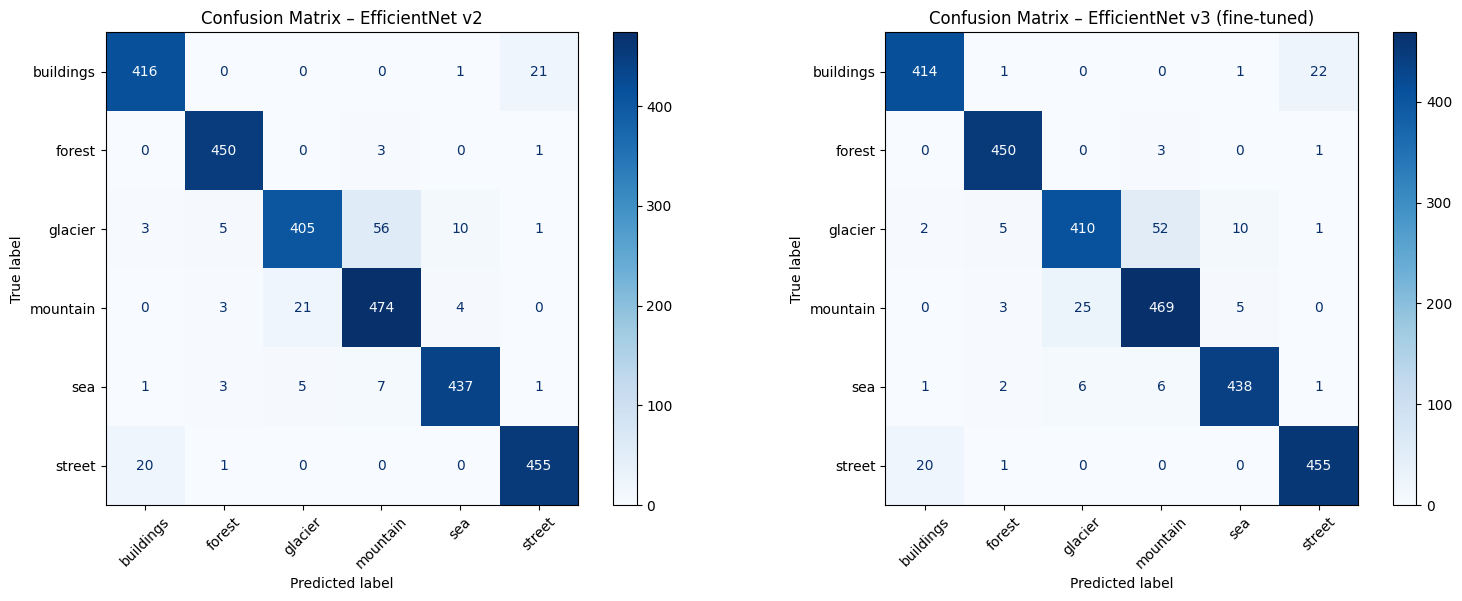

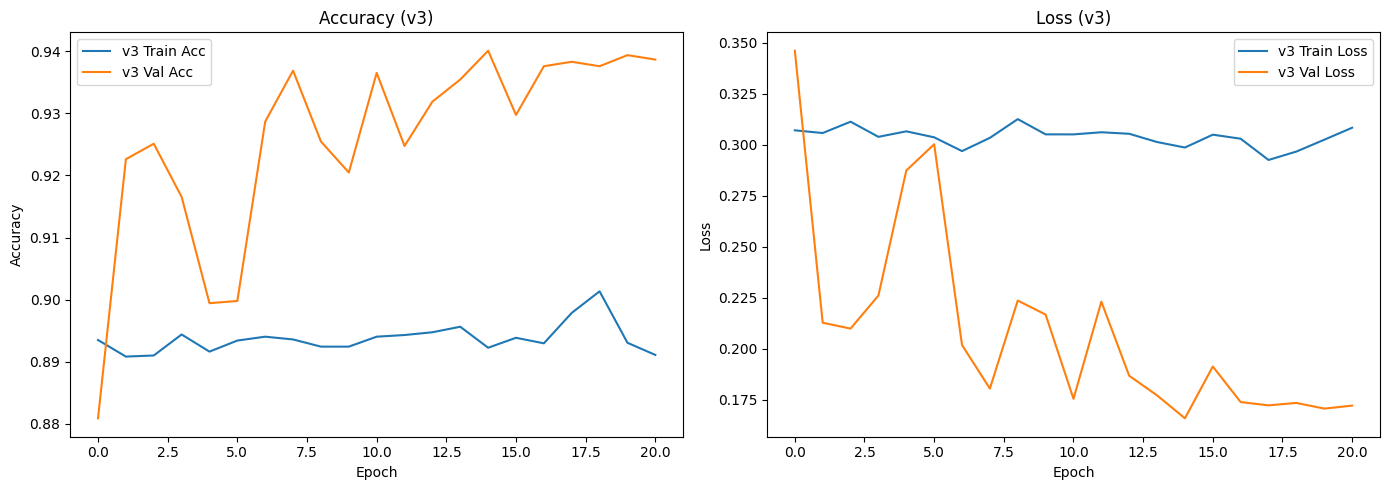

In [ ]:
model_v2 = load_model('models/transfer_enb0_v2.keras')
model_v3 = load_model('models/transfer_enb0_v3_finetuned.keras')

val_generator.reset()
val_preds_v2 = model_v2.predict(val_generator)
val_preds_v3 = model_v3.predict(val_generator)

y_true = val_generator.classes
y_pred_v2 = np.argmax(val_preds_v2, axis=1)
y_pred_v3 = np.argmax(val_preds_v3, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
cm_v2 = confusion_matrix(y_true, y_pred_v2)
cm_v3 = confusion_matrix(y_true, y_pred_v3)

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_v2, display_labels=val_generator.class_indices.keys())
disp1.plot(cmap="Blues", ax=axes[0], xticks_rotation=45, values_format="d")
axes[0].set_title("Confusion Matrix – EfficientNet v2")

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_v3, display_labels=val_generator.class_indices.keys())
disp2.plot(cmap="Blues", ax=axes[1], xticks_rotation=45, values_format="d")
axes[1].set_title("Confusion Matrix – EfficientNet v3 (fine-tuned)")

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='v3 Train Acc')
plt.plot(history.history['val_accuracy'], label='v3 Val Acc')
plt.title('Accuracy (v3)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='v3 Train Loss')
plt.plot(history.history['val_loss'], label='v3 Val Loss')
plt.title('Loss (v3)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("=== Classification Report v2 ===")
print(classification_report(y_true, y_pred_v2, target_names=val_generator.class_indices.keys()))

print("\n=== Classification Report v3 (fine-tuned) ===")
print(classification_report(y_true, y_pred_v3, target_names=val_generator.class_indices.keys()))

=== Classification Report v2 ===
              precision    recall  f1-score   support

   buildings       0.96      0.95      0.95       438
      forest       0.97      1.00      0.98       454
     glacier       0.93      0.84      0.89       480
    mountain       0.89      0.94      0.91       502
         sea       0.96      0.97      0.96       454
      street       0.96      0.97      0.97       476

    accuracy                           0.94      2804
   macro avg       0.95      0.94      0.94      2804
weighted avg       0.94      0.94      0.94      2804


=== Classification Report v3 (fine-tuned) ===
              precision    recall  f1-score   support

   buildings       0.97      0.95      0.96       438
      forest       0.97      1.00      0.99       454
     glacier       0.94      0.84      0.89       480
    mountain       0.89      0.94      0.91       502
         sea       0.97      0.97      0.97       454
      street       0.96      0.98      0.97       47

Porównanie wyników modelu przed i po dodatkowym fine tuningu pokazuje, że choć zmiany nie są ogromne, to nastąpiła korzystna poprawa w jakości klasyfikacji.

Macierze pomyłek nie wskazują większych zmian, a raporty klasyfikacji potwierdzają, że precision i recall delikatnie wzrosły lub utrzymały się na wysokim poziomie. Wersja v3 uzyskała ogólną dokładność na poziomie 95%, poprawiając wynik względem v2, gdzie było to 94%.

Ponieważ powyższy fine tuning nie wprowadził znaczących zmian w wynikach modelu, dalsza optymalizacja modelu nie została przeprowadzana - dogonił on i tak już swoją dokładnością pozostałe dwa modele, których fine tuning przeprowadzony zostanie w kolejnych krokach.

### MobileNetV2 i InceptionV3
Przeprowadzono fine tuning modeli MobileNetV2 i InceptionV3 w podobny sposób jak wcześniej dla EfficientNetB0, aby dodatkowo poprawić ich dopasowanie do zbioru danych. Wprowadzono umiarkowaną augmentację obrazów treningowych, aby zwiększyć różnorodność danych wejściowych bez zbyt dużego zakłócania ich struktury.

Proces fine tuningu polegał na selektywnym odmrożeniu ostatnich warstw modeli: dla MobileNetV2 ostatnich 100 warstw, a dla InceptionV3 ostatnich 200 warstw.
Użyto niewielkiego tempa uczenia, aby zmiany wag były delikatne i nie niszczyły wcześniejszych wartościowych reprezentacji. Zastosowano także `label smoothing` podczas obliczania straty, co pomaga uczynić model bardziej odpornym na potencjalne błędy w etykietach lub trudniejsze przykłady.

Cała procedura miała na celu jeszcze bardziej zwiększyć skuteczność modeli bez ryzyka przeuczenia.

In [ ]:
fine_tune_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
)

fine_tune_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator_aug = fine_tune_train_datagen.flow_from_directory(
    '/content/intel_data/train',
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical'
)

val_generator = fine_tune_val_datagen.flow_from_directory(
    '/content/intel_data/val',
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

def fine_tune_model(model_path, save_path, fine_tune_at_layer=100):
    print(f"\nFine-tuning modelu: {model_path}")
    model = load_model(model_path)

    # odmrazanie od końca
    for layer in model.layers[:-fine_tune_at_layer]:
        layer.trainable = False
    for layer in model.layers[-fine_tune_at_layer:]:
        layer.trainable = True

    model.compile(
        optimizer=Adam(learning_rate=5e-5),
        loss=CategoricalCrossentropy(label_smoothing=0.05),
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
        ModelCheckpoint(save_path, save_best_only=True)
    ]

    history = model.fit(
        train_generator_aug,
        validation_data=val_generator,
        epochs=30,
        callbacks=callbacks,
        verbose=1
    )

    return model, history


model_mnv2, history_mnv2 = fine_tune_model(
    model_path='models/transfer_mnv2_v1.keras',
    save_path='models/transfer_mnv2_v2.keras',
    fine_tune_at_layer=100
)

model_iv3, history_iv3 = fine_tune_model(
    model_path='models/transfer_iv3_v1.keras',
    save_path='models/transfer_iv3_v2.keras',
    fine_tune_at_layer=200
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.

Fine-tuning modelu: models/transfer_mnv2_v1.keras
Epoch 1/30
702/702 ━━━━━━━━━━━━━━━━━━━━ 131s 140ms/step - accuracy: 0.7949 - loss: 0.7795 - val_accuracy: 0.8930 - val_loss: 0.6095 - learning_rate: 5.0000e-05
Epoch 2/30
702/702 ━━━━━━━━━━━━━━━━━━━━ 76s 108ms/step - accuracy: 0.8768 - loss: 0.5693 - val_accuracy: 0.9105 - val_loss: 0.5072 - learning_rate: 5.0000e-05
Epoch 3/30
702/702 ━━━━━━━━━━━━━━━━━━━━ 76s 108ms/step - accuracy: 0.8940 - loss: 0.5229 - val_accuracy: 0.9198 - val_loss: 0.4707 - learning_rate: 5.0000e-05
Epoch 4/30
702/702 ━━━━━━━━━━━━━━━━━━━━ 76s 108ms/step - accuracy: 0.9120 - loss: 0.4831 - val_accuracy: 0.9269 - val_loss: 0.4466 - learning_rate: 5.0000e-05
Epoch 5/30
702/702 ━━━━━━━━━━━━━━━━━━━━ 76s 108ms/step - accuracy: 0.9193 - loss: 0.4705 - val_accuracy: 0.9312 - val_loss: 0.4385 - learning_rate: 5.0000e-05
Epoch 6/30
702/702 ━━━━━━━━━━━━━━━━━━━━ 77s 109ms/step - accuracy: 0

176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9271 - loss: 0.1816
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9347 - loss: 0.4227
176/176 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.9208 - loss: 0.2137
176/176 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.9291 - loss: 0.4244


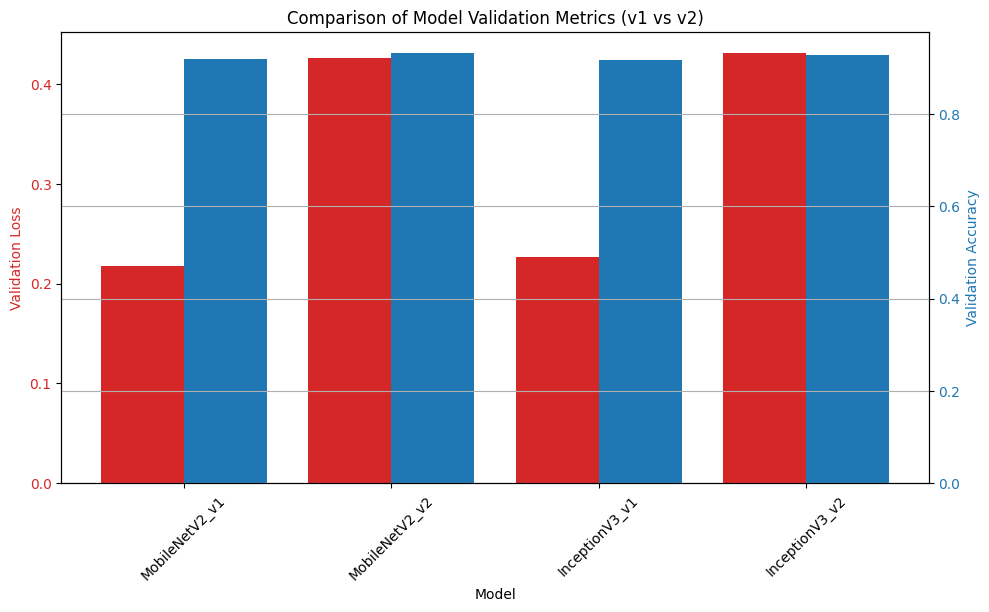


Validation results:
MobileNetV2_v1 - Accuracy: 0.9198, Loss: 0.2175
MobileNetV2_v2 - Accuracy: 0.9308, Loss: 0.4266
InceptionV3_v1 - Accuracy: 0.9173, Loss: 0.2263
InceptionV3_v2 - Accuracy: 0.9283, Loss: 0.4306


In [ ]:
def evaluate_model(model_path, val_generator):
    model = tf.keras.models.load_model(model_path)
    loss, acc = model.evaluate(val_generator, verbose=1)
    return loss, acc

model_paths = {
    'MobileNetV2_v1': 'models/transfer_mnv2_v1.keras',
    'MobileNetV2_v2': 'models/transfer_mnv2_v2.keras',
    'InceptionV3_v1': 'models/transfer_iv3_v1.keras',
    'InceptionV3_v2': 'models/transfer_iv3_v2.keras'
}

results = {}

for name, path in model_paths.items():
    loss, acc = evaluate_model(path, val_generator)
    results[name] = {'val_loss': loss, 'val_accuracy': acc}


labels = list(results.keys())
losses = [results[label]['val_loss'] for label in labels]
accuracies = [results[label]['val_accuracy'] for label in labels]

x = np.arange(len(labels))

fig, ax1 = plt.subplots(figsize=(10,6))

color = 'tab:red'
ax1.set_xlabel('Model')
ax1.set_ylabel('Validation Loss', color=color)
ax1.bar(x - 0.2, losses, width=0.4, color=color, label='Val Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy', color=color)
ax2.bar(x + 0.2, accuracies, width=0.4, color=color, label='Val Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Comparison of Model Validation Metrics (v1 vs v2)')
plt.grid(True)
plt.show()

print("\nValidation results:")
for model_name, metrics in results.items():
    print(f"{model_name} - Accuracy: {metrics['val_accuracy']:.4f}, Loss: {metrics['val_loss']:.4f}")


Wstępne wyniki walidacji dla modeli po pierwszym fine tuningu pokazują, że mimo zauważalnej poprawy dokładności względem pierwotnych wersji, pojawiły się pewne problemy ze stabilnością uczenia.

Choć MobileNetV2_v2 i InceptionV3_v2 osiągnęły wyższą dokładność (odpowiednio 93,08% i 92,83%) niż ich wersje v1, ich straty walidacyjne są wyraźnie większe niż wcześniejsze, co sugeruje, że modele mogły zacząć się przeuczać lub że proces dostrajania nie był optymalnie kontrolowany. Wysoka dokładność przy rosnącej stracie może wskazywać na zbyt agresywne dostosowanie do danych treningowych przy niedostatecznej generalizacji.

Aby poprawić stabilność procesu dostrajania, wprowadzono kilka zmian. Zastosowano łagodniejszą augmentację obrazów, zmniejszając zakres rotacji, przesunięć i zoomu, aby nie zakłócać zbytnio struktury danych. Obniżono także tempo uczenia do 1e-5 oraz ograniczono liczbę odmrożonych warstw, dzięki czemu modyfikacje wag w modelu będą bardziej subtelne i bezpieczne. Nowe ustawienia miały na celu lepsze dopasowanie modeli przy zachowaniu niskiej straty walidacyjnej, co w praktyce powinno przełożyć się na jeszcze lepszą generalizację na danych testowych.

In [ ]:
fine_tune_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
)

fine_tune_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator_aug = fine_tune_train_datagen.flow_from_directory(
    '/content/intel_data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = fine_tune_val_datagen.flow_from_directory(
    '/content/intel_data/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

def fine_tune_model(model_path, save_path, fine_tune_at_layer=50, learning_rate=1e-5):
    print(f"\nFine-tuning modelu: {model_path}")
    model = load_model(model_path)

    # odmrazamy ostatnie warstwy
    for layer in model.layers[:-fine_tune_at_layer]:
        layer.trainable = False
    for layer in model.layers[-fine_tune_at_layer:]:
        layer.trainable = True

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=CategoricalCrossentropy(),
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
        ModelCheckpoint(save_path, save_best_only=True)
    ]

    history = model.fit(
        train_generator_aug,
        validation_data=val_generator,
        epochs=30,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

model_mnv2, history_mnv2 = fine_tune_model(
    model_path='models/transfer_mnv2_v1.keras',
    save_path='models/transfer_mnv2_v2_finetuned.keras',
    fine_tune_at_layer=50,
    learning_rate=5e-5
)

model_iv3, history_iv3 = fine_tune_model(
    model_path='models/transfer_iv3_v1.keras',
    save_path='models/transfer_iv3_v2_finetuned.keras',
    fine_tune_at_layer=100,
    learning_rate=5e-5
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.

Fine-tuning modelu: models/transfer_mnv2_v1.keras


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 104s 234ms/step - accuracy: 0.8281 - loss: 0.4864 - val_accuracy: 0.9087 - val_loss: 0.2828 - learning_rate: 5.0000e-05
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 195ms/step - accuracy: 0.9033 - loss: 0.2668 - val_accuracy: 0.9144 - val_loss: 0.2549 - learning_rate: 5.0000e-05
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 65s 186ms/step - accuracy: 0.9058 - loss: 0.2509 - val_accuracy: 0.9141 - val_loss: 0.2547 - learning_rate: 5.0000e-05
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 197ms/step - accuracy: 0.9281 - loss: 0.1976 - val_accuracy: 0.9148 - val_loss: 0.2672 - learning_rate: 5.0000e-05
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 68s 194ms/step - accuracy: 0.9341 - loss: 0.1777 - val_accuracy: 0.9112 - val_loss: 0.2750 - learning_rate: 5.0000e-05
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 66s 189ms/step - accuracy: 0.9451 - loss: 0.1482 - val_accuracy: 0.9255 - val_loss: 0.2232 - learning_rate: 2.5000e-05
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 65s 1

88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9279 - loss: 0.1920
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9383 - loss: 0.1851
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.9093 - loss: 0.2316
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.9308 - loss: 0.1902


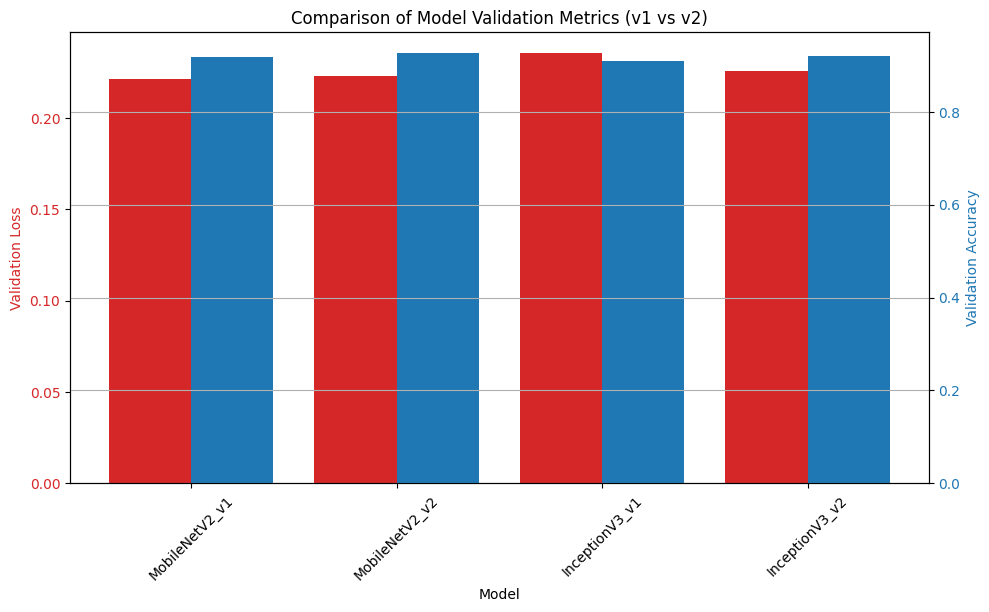


Validation results:
MobileNetV2_v1 - Accuracy: 0.9180, Loss: 0.2213
MobileNetV2_v2 - Accuracy: 0.9255, Loss: 0.2232
InceptionV3_v1 - Accuracy: 0.9083, Loss: 0.2353
InceptionV3_v2 - Accuracy: 0.9208, Loss: 0.2257


In [ ]:
def evaluate_model(model_path, val_generator):
    model = tf.keras.models.load_model(model_path)
    loss, acc = model.evaluate(val_generator, verbose=1)
    return loss, acc

model_paths = {
    'MobileNetV2_v1': 'models/transfer_mnv2_v1.keras',
    'MobileNetV2_v2': 'models/transfer_mnv2_v2_finetuned.keras',
    'InceptionV3_v1': 'models/transfer_iv3_v1.keras',
    'InceptionV3_v2': 'models/transfer_iv3_v2_finetuned.keras'
}

results = {}

for name, path in model_paths.items():
    loss, acc = evaluate_model(path, val_generator)
    results[name] = {'val_loss': loss, 'val_accuracy': acc}


labels = list(results.keys())
losses = [results[label]['val_loss'] for label in labels]
accuracies = [results[label]['val_accuracy'] for label in labels]

x = np.arange(len(labels))

fig, ax1 = plt.subplots(figsize=(10,6))

color = 'tab:red'
ax1.set_xlabel('Model')
ax1.set_ylabel('Validation Loss', color=color)
ax1.bar(x - 0.2, losses, width=0.4, color=color, label='Val Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy', color=color)
ax2.bar(x + 0.2, accuracies, width=0.4, color=color, label='Val Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Comparison of Model Validation Metrics (v1 vs v2)')
plt.grid(True)
plt.show()

print("\nValidation results:")
for model_name, metrics in results.items():
    print(f"{model_name} - Accuracy: {metrics['val_accuracy']:.4f}, Loss: {metrics['val_loss']:.4f}")


Druga wersja fine tuningu dla modeli MobileNetV2 i InceptionV3 przyniosła bardziej stabilne wyniki, jednak poprawy względem pierwotnego podejścia okazały się niewielkie.

Wyniki pokazują, że modele po fine tuningu osiągnęły dobre poziomy dokładności — MobileNetV2_v2 uzyskał 92,55% przy stracie 0,2232, a InceptionV3_v2 osiągnął 92,08% dokładności przy stracie 0,2257. Straty walidacyjne są teraz zdecydowanie niższe niż po pierwszym podejściu do dostrajania, co świadczy o lepszym dopasowaniu modeli bez przeuczenia.

Jednocześnie dalsze próby poprawy wyników nie przynoszą już znaczących korzyści — dokładność zatrzymała się na bardzo dobrym poziomie, a strata przestała istotnie się zmieniać. Dlatego nie będzie sensu kontynuować kolejnych prób dostrajania, ponieważ aktualnie uzyskane modele prezentują już bardzo wysoką jakość i dobrą równowagę pomiędzy dokładnością a stratą.

## Końcowe porównanie wyników
Wykorzystano wcześniej wspomniany zbiór `seg_test`, który był osobno wydzielony w dostępnym zestawie danych i zawiera obrazy przypisane do odpowiednich klas, co umożliwia pełną i rzetelną ocenę jakości modeli na nieznanych wcześniej danych.

Dane testowe zostały wczytane za pomocą generatora ImageDataGenerator bez augmentacji, aby ocena odzwierciedlała rzeczywistą skuteczność modeli bez sztucznych przekształceń obrazów. Obrazy zostały odpowiednio przeskalowane i przygotowane w formie uporządkowanej, zachowując strukturę klas.

In [ ]:
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test/'

classes = os.listdir(test_dir)
print("Classes:", classes)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Classes: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']
Found 3000 images belonging to 6 classes.


In [ ]:
def calculate_iou_dice(y_true, y_pred):
    intersection = np.sum(np.logical_and(y_true, y_pred))
    union = np.sum(np.logical_or(y_true, y_pred))
    iou = intersection / union if union != 0 else 0
    dice = (2. * intersection) / (np.sum(y_true) + np.sum(y_pred)) if (np.sum(y_true) + np.sum(y_pred)) != 0 else 0
    return iou, dice

def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

Poniżej znajdują się macierze pomyłek dla kolejnych par modeli: podstawowa wersja CNN oraz CNN po ostatecznym fine tuningu, pierwsza wersja modelu EfficientNetB0 oraz wersja po optymalizacji, a następnie modele MobileNetV2 i InceptionV3 odpowiednio przed i po fine tuningu.

Testing cnn_v1...
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step


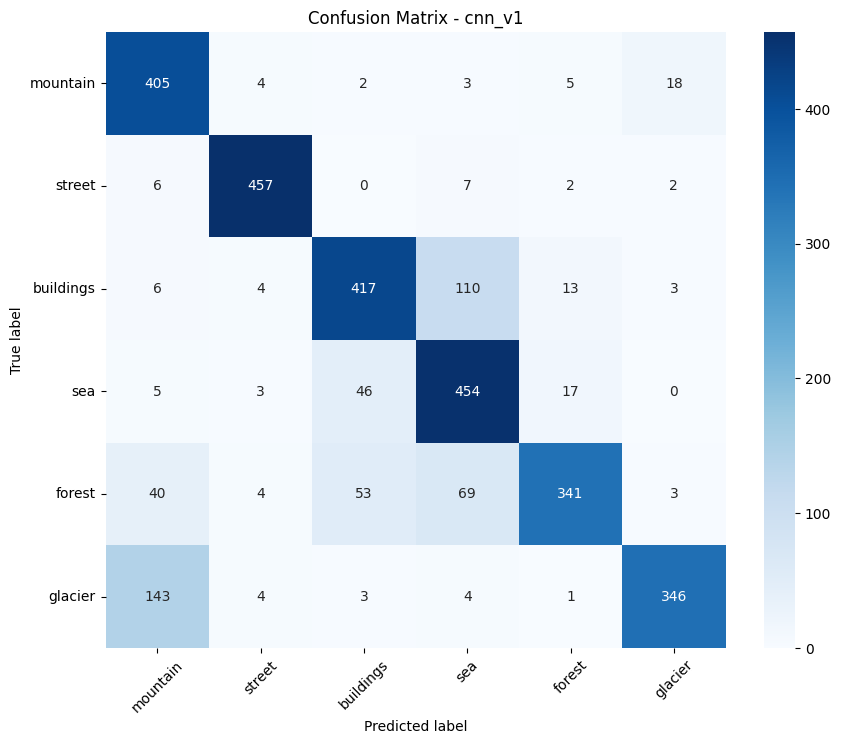

Testing cnn_v4_finetuned...
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step


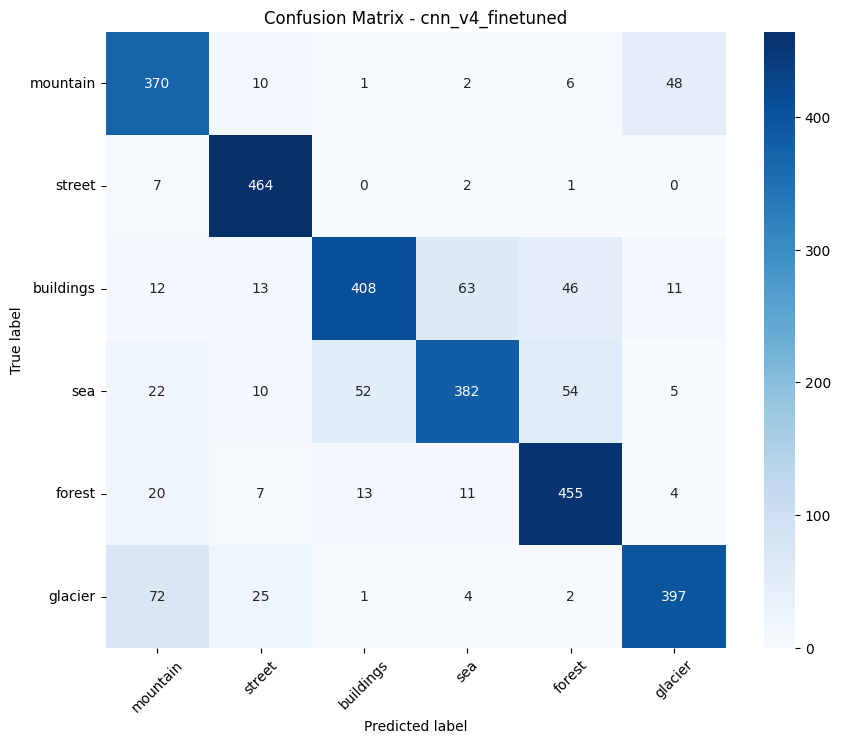

Testing transfer_enb0_v1...
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


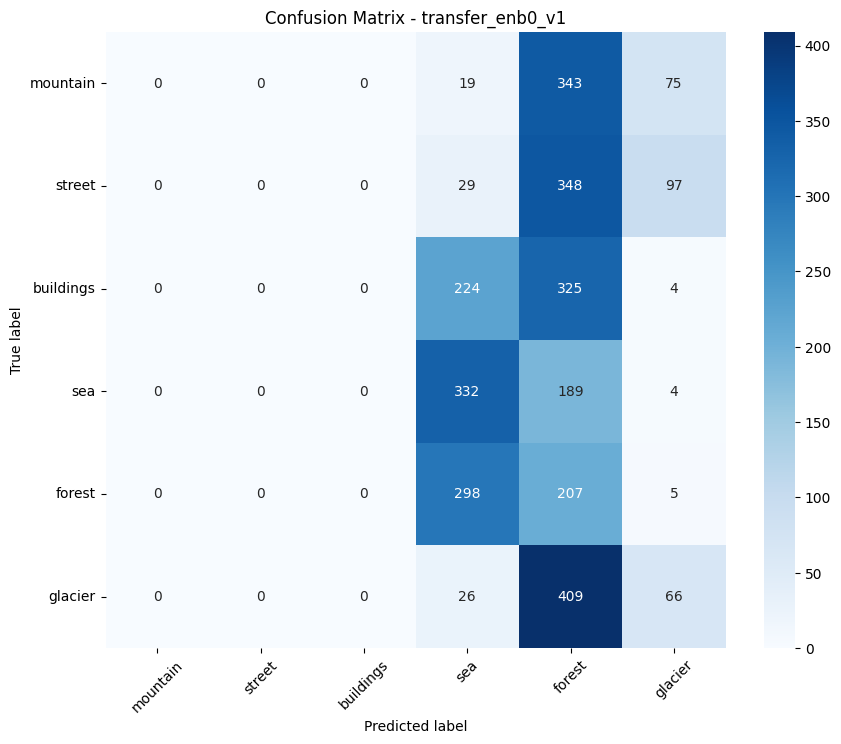

Testing transfer_enb0_v3_finetuned...
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 107ms/step


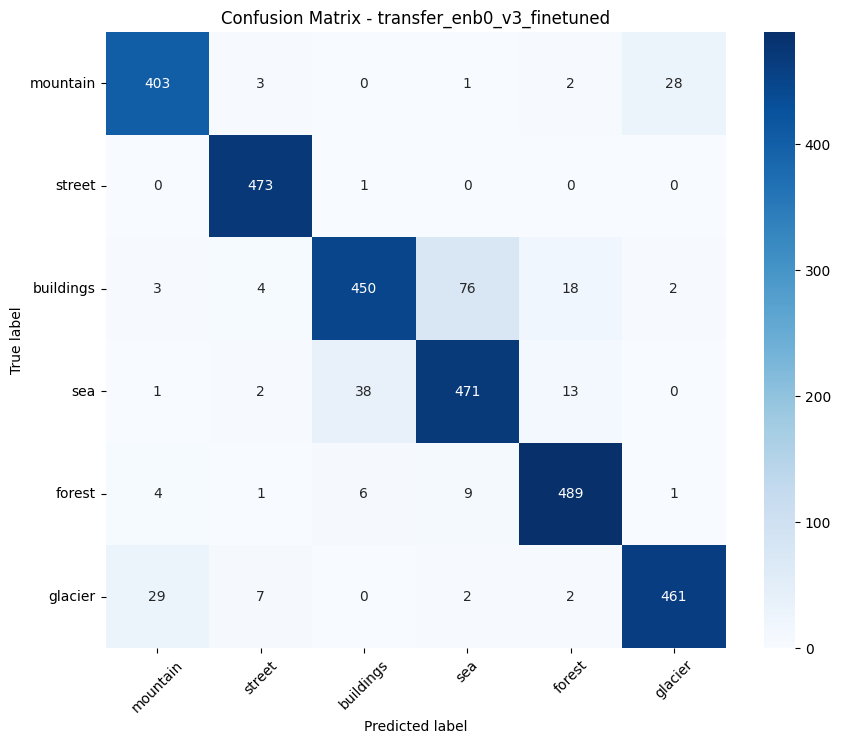

Testing transfer_mnv2_v1...
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step


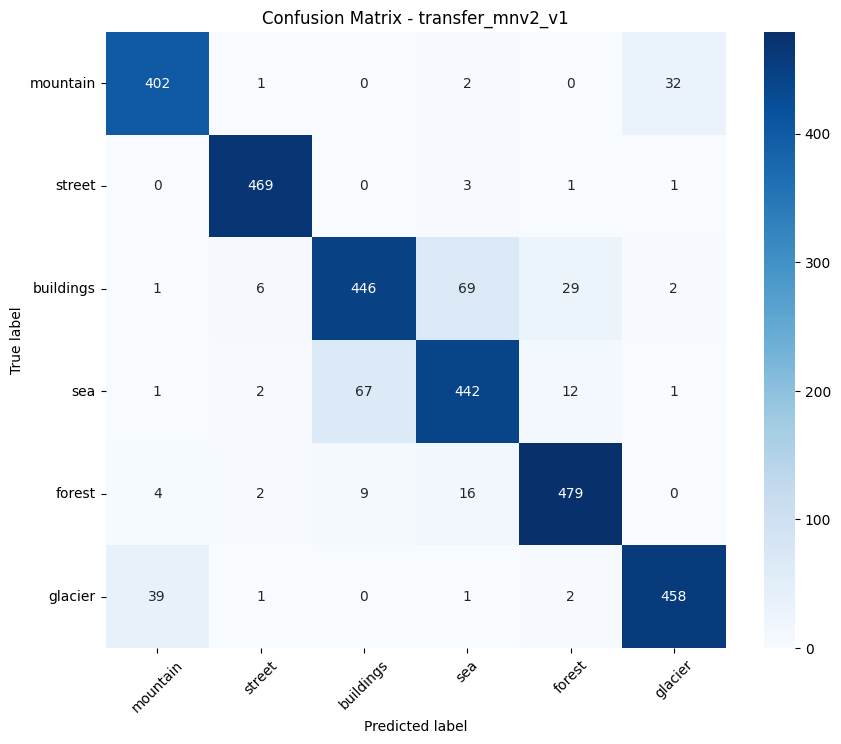

Testing transfer_mnv2_v2_finetuned...
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step


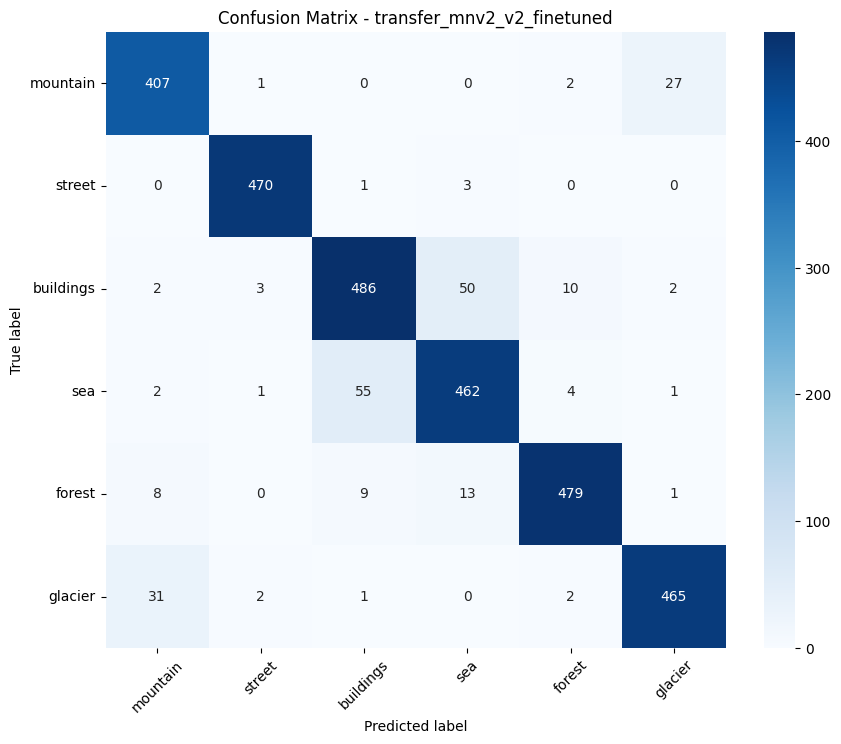

Testing transfer_iv3_v1...
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step


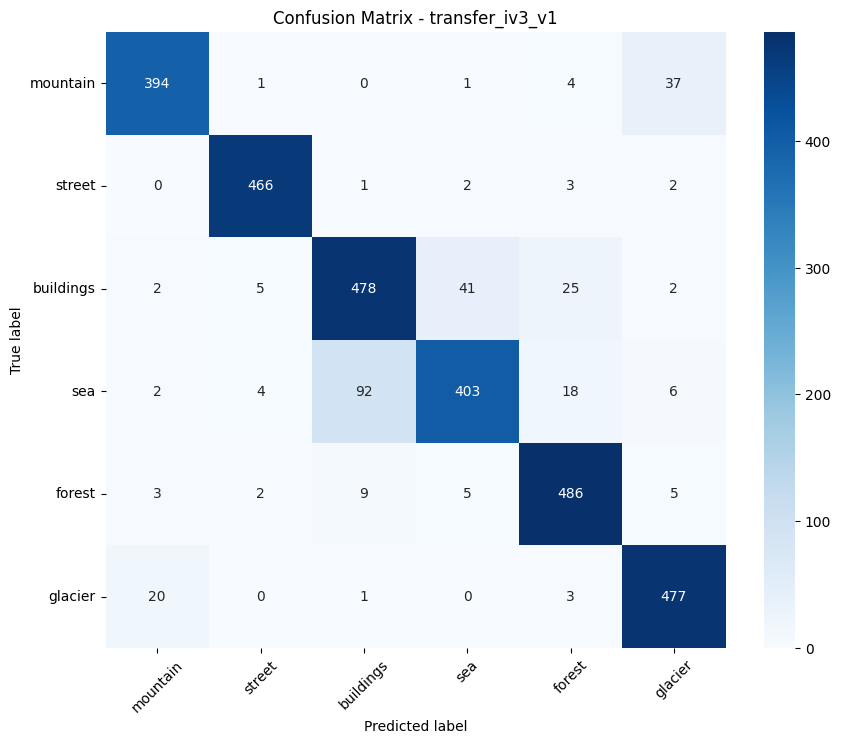

Testing transfer_iv3_v2_finetuned...
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step


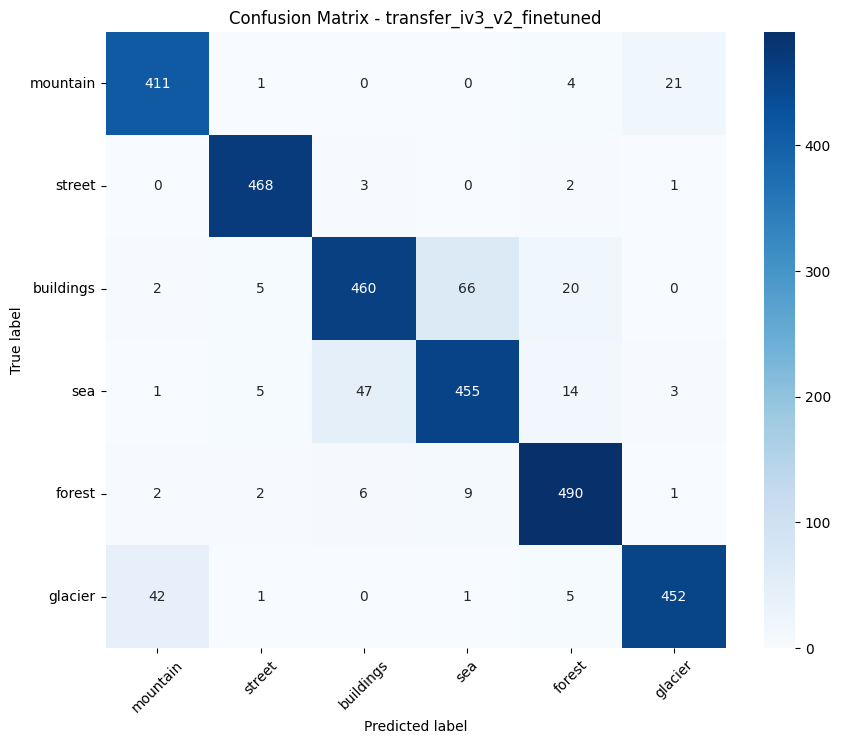

In [ ]:
model_files = [
    'models/cnn_v1.keras',
    'models/cnn_v4_finetuned.keras',
    'models/transfer_enb0_v1.keras',
    'models/transfer_enb0_v3_finetuned.keras',
    'models/transfer_mnv2_v1.keras',
    'models/transfer_mnv2_v2_finetuned.keras',
    'models/transfer_iv3_v1.keras',
    'models/transfer_iv3_v2_finetuned.keras'
]

model_names = [os.path.basename(m).replace('.keras', '') for m in model_files]

results = {
    'Model': [],
    'Accuracy': [],
    'Loss': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'IoU': [],
    'Dice': []
}

for model_file, model_name in zip(model_files, model_names):
    print(f"Testing {model_name}...")

    model = load_model(model_file)
    loss, accuracy = model.evaluate(test_generator, verbose=0)

    y_pred_probs = model.predict(test_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = test_generator.classes

    # accuracy = np.mean(y_pred_classes == y_true_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

    y_true_bin = tf.keras.utils.to_categorical(y_true_classes, num_classes=len(classes))
    y_pred_bin = tf.keras.utils.to_categorical(y_pred_classes, num_classes=len(classes))

    ious = []
    dices = []
    for i in range(len(classes)):
        iou, dice = calculate_iou_dice(y_true_bin[:, i], y_pred_bin[:, i])
        ious.append(iou)
        dices.append(dice)

    mean_iou = np.mean(ious)
    mean_dice = np.mean(dices)

    results['Model'].append(model_name)
    results['Accuracy'].append(accuracy)
    results['Loss'].append(loss)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1-Score'].append(f1)
    results['IoU'].append(mean_iou)
    results['Dice'].append(mean_dice)

    plot_confusion_matrix(y_true_classes, y_pred_classes, classes, model_name)

Porównując macierze pomyłek dla modelu `cnn_v1`, widać istotną różnicę między wynikami osiągniętymi wcześniej na zbiorze walidacyjnym a wynikami osiągniętymi teraz na zbiorze testowym. Dla zbioru walidacyjnego była ona bardzo chaotyczna — wyniki były rozproszone, model często mylił różne klasy między sobą, a poprawnych predykcji było stosunkowo niewiele. Natomiast na zbiorze testowym widoczna jest silna, wyraźna przekątna, co oznacza, że większość predykcji jest poprawna. Model znacznie lepiej rozróżnia klasy, prawidłowo przypisując obrazy do właściwych kategorii. Oznacza to, że na zbiorze testowym model osiągnął znacznie lepsze wyniki niż na zbiorze walidacyjnym, z czym się osobiście jeszcze nie spotkałam, więc było to niemałym zaskoczeniem. Możliwe, że obrazy w zbiorze testowym są bardziej charakterystyczne, mniej zróżnicowane lub mniej zakłócone, co ułatwia modelowi klasyfikację lub niektóre wzorce powtórzyły się ze zbioru treningowego.

Niemniej jednak wersja po optymalizacji (`cnn_v4_finetuned`) pokazuje znaczną poprawę, tak samo jak w przypadku pozostałych modeli, zatem proces ich optymalizacji można ogólnie uznać za udany.

### Podsumowanie wyników

In [ ]:
results_df = pd.DataFrame(results)
display(results_df.round(4).style.background_gradient(cmap="Blues"))

Końcowe porównanie wyników na zbiorze testowym jasno pokazuje, jak zmieniała się jakość poszczególnych modeli i jak skutecznie zadziałał transfer learning oraz fine tuning.

Model `cnn_v1` osiągnął accuracy na poziomie około 80,7% i f1-score około 80,7%, co o ile znacznie odstaje od wyników na zbiorze walidacyjnym, to jest przyzwoitym wynikiem jak na prostą, własnoręcznie zbudowaną sieć, ale wyraźnie ustępuje późniejszym, bardziej zaawansowanym modelom.

Model `cnn_v4_finetuned` poprawił wyniki w stosunku do pierwotnej wersji, osiągając accuracy 82,5% i nieco lepsze metryki IoU oraz Dice, co wskazuje na skuteczniejsze rozpoznawanie bardziej złożonych wzorców.

Model `transfer_enb0_v1` (pierwsza, niedostrojona wersja `EfficientNetB0`) wypadł bardzo słabo — accuracy wyniosło zaledwie 20%, a pozostałe metryki były bardzo niskie. Dopiero po pełnym fine tuningu (`transfer_enb0_v3_finetuned`) EfficientNetB0 osiągnął accuracy 91,6% i bardzo wysokie precision, recall, f1-score, IoU i Dice, co pokazuje ogromny wpływ dostosowania wag sieci do nowego zadania.

`MobileNetV2` w wersji podstawowej (`transfer_mnv2_v1`) i po fine tuningu (`transfer_mnv2_v2_finetuned`) również uzyskał bardzo dobre wyniki — fine tuning podniósł accuracy z 89,9% do 92,3%, a f1-score i inne miary osiągnęły bardzo wysokie wartości.

Podobny efekt widać dla `InceptionV3` — z accuracy 90,1% w wersji podstawowej do 91,2% po fine tuningu, przy jednoczesnym zauważalnym wzroście IoU i Dice.

<ipython-input-28-cc5fb5027692>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


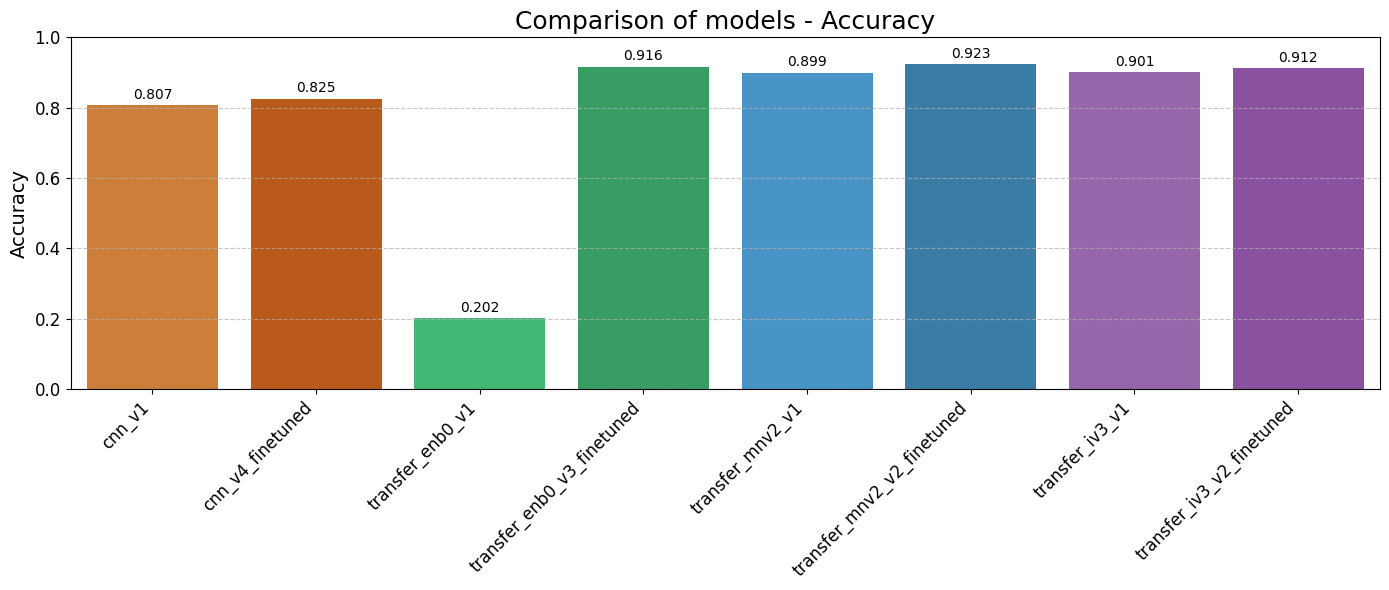

<ipython-input-28-cc5fb5027692>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


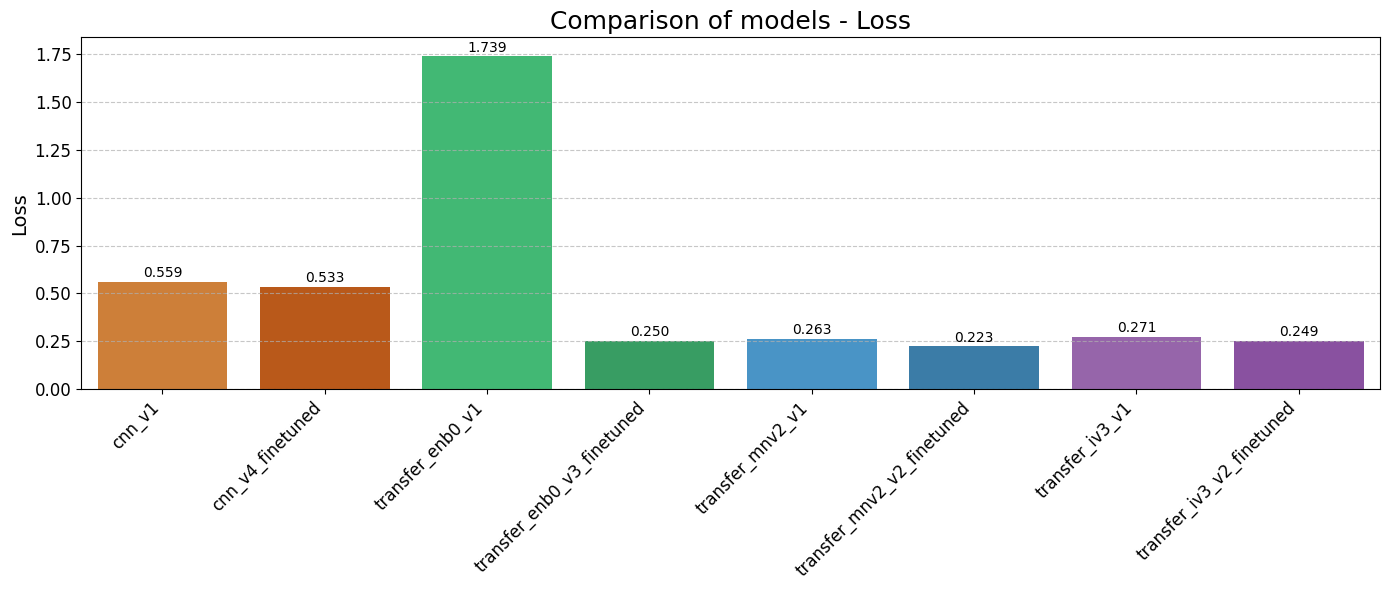

<ipython-input-28-cc5fb5027692>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


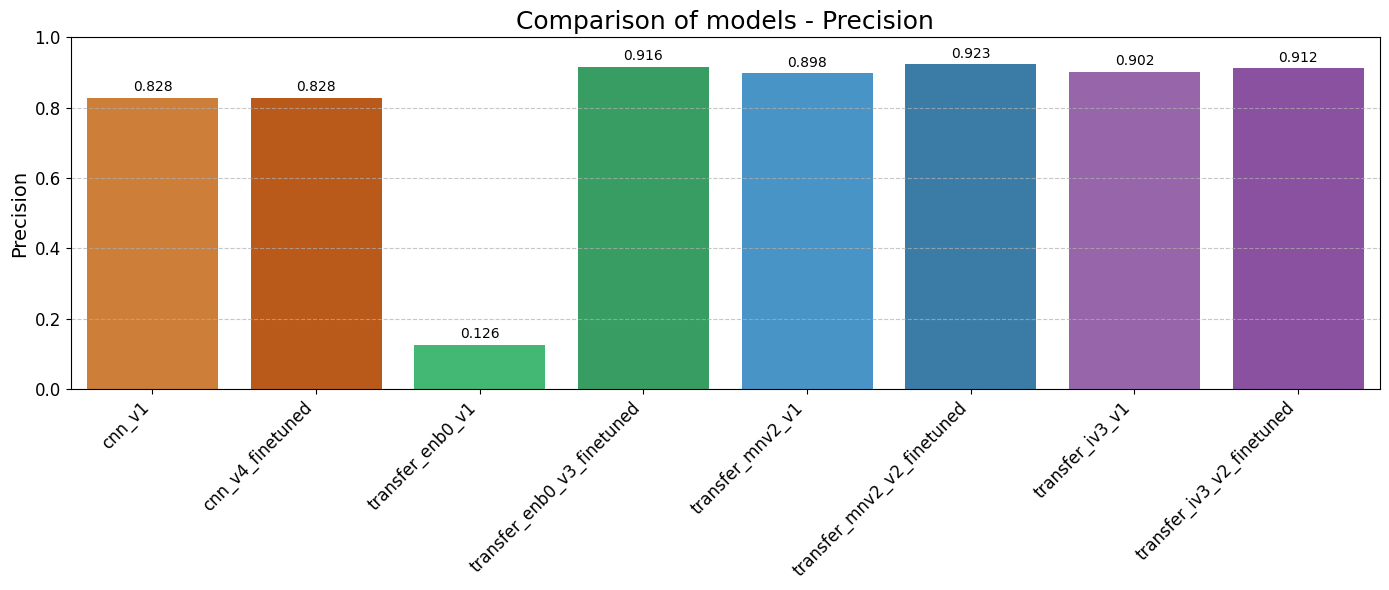

<ipython-input-28-cc5fb5027692>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


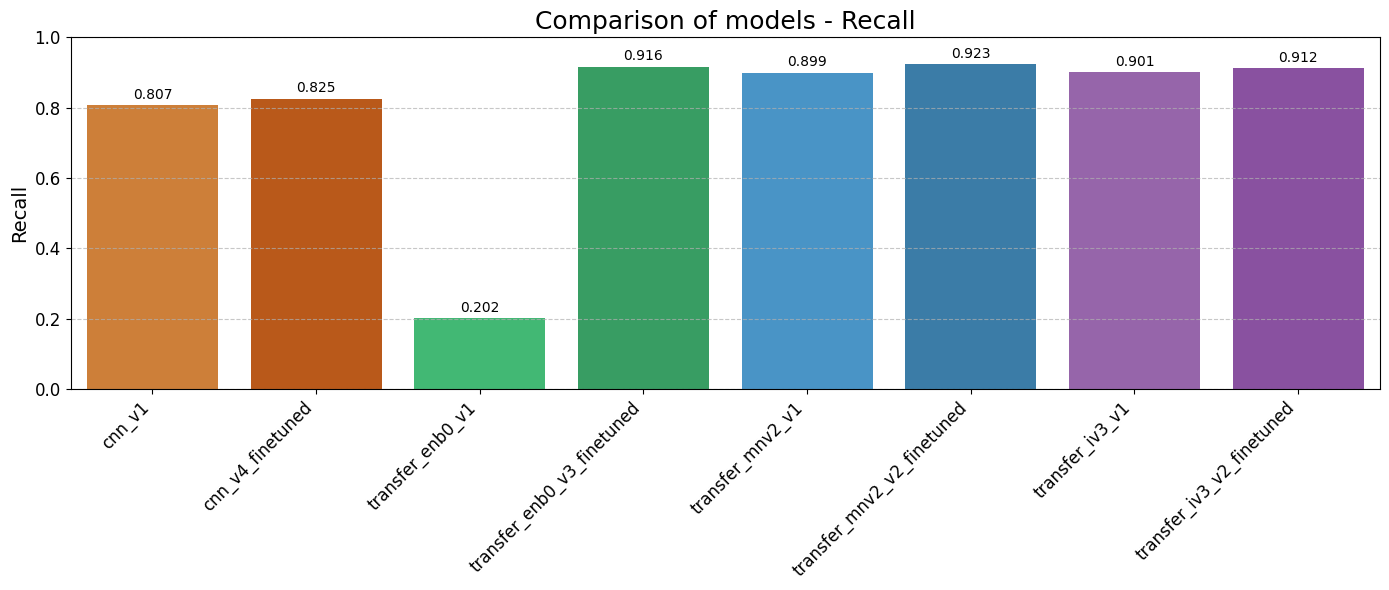

<ipython-input-28-cc5fb5027692>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


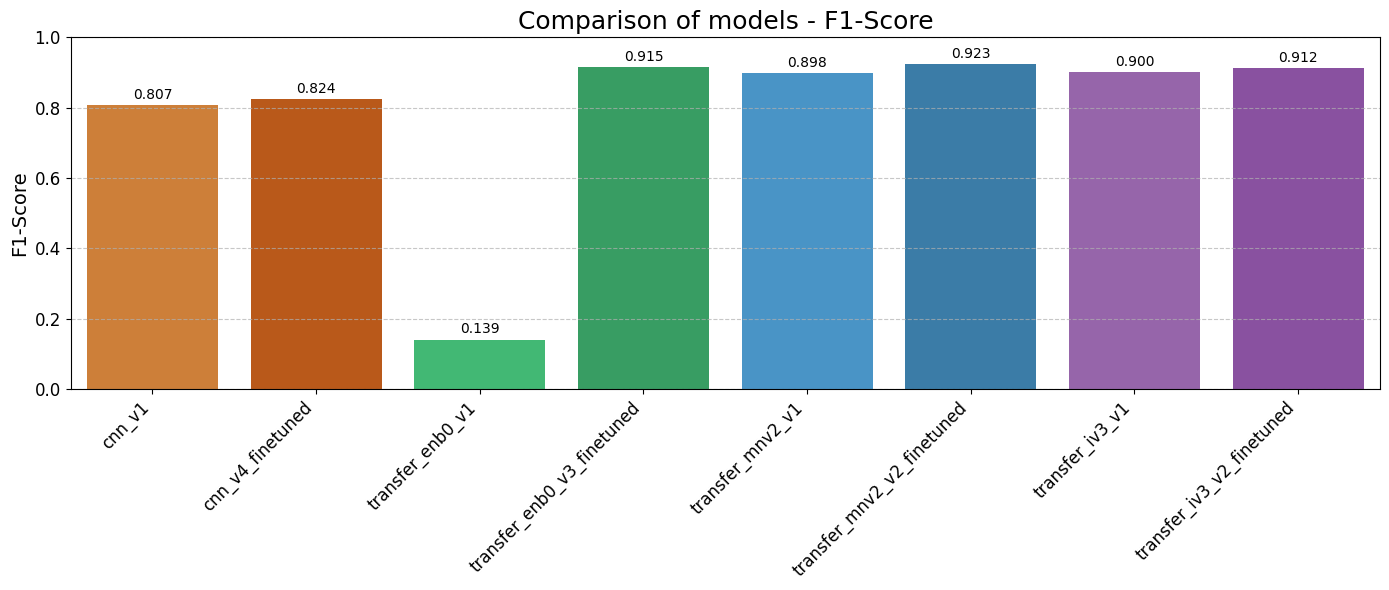

<ipython-input-28-cc5fb5027692>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


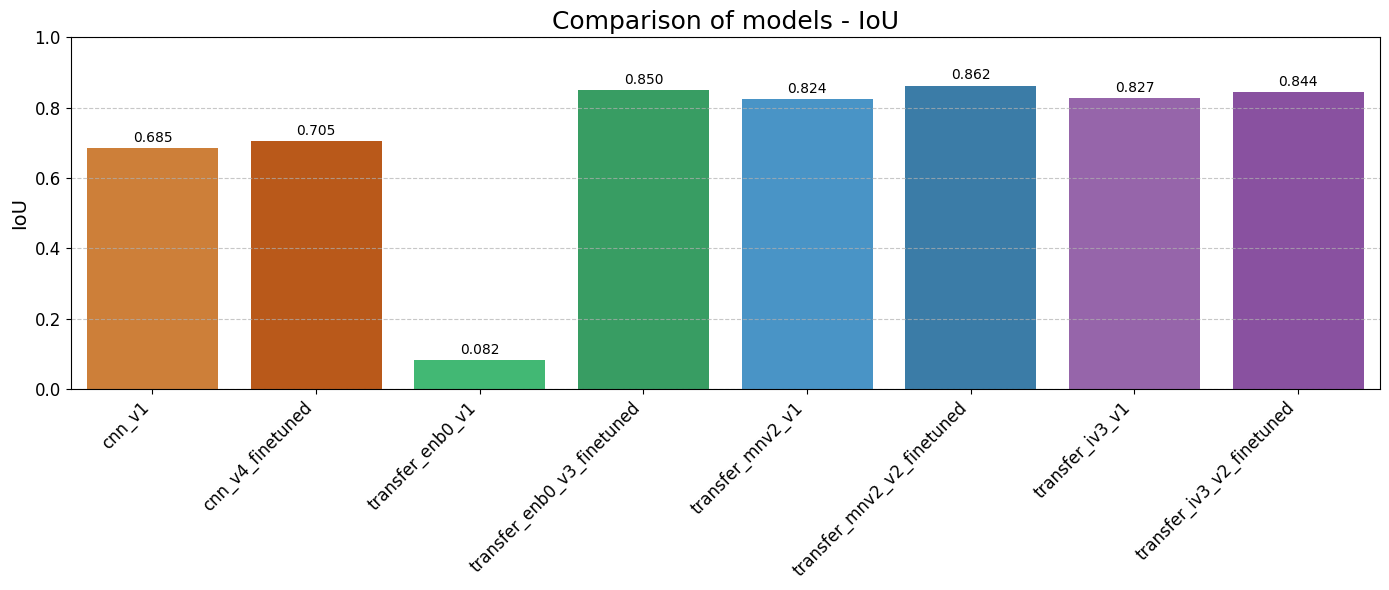

<ipython-input-28-cc5fb5027692>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


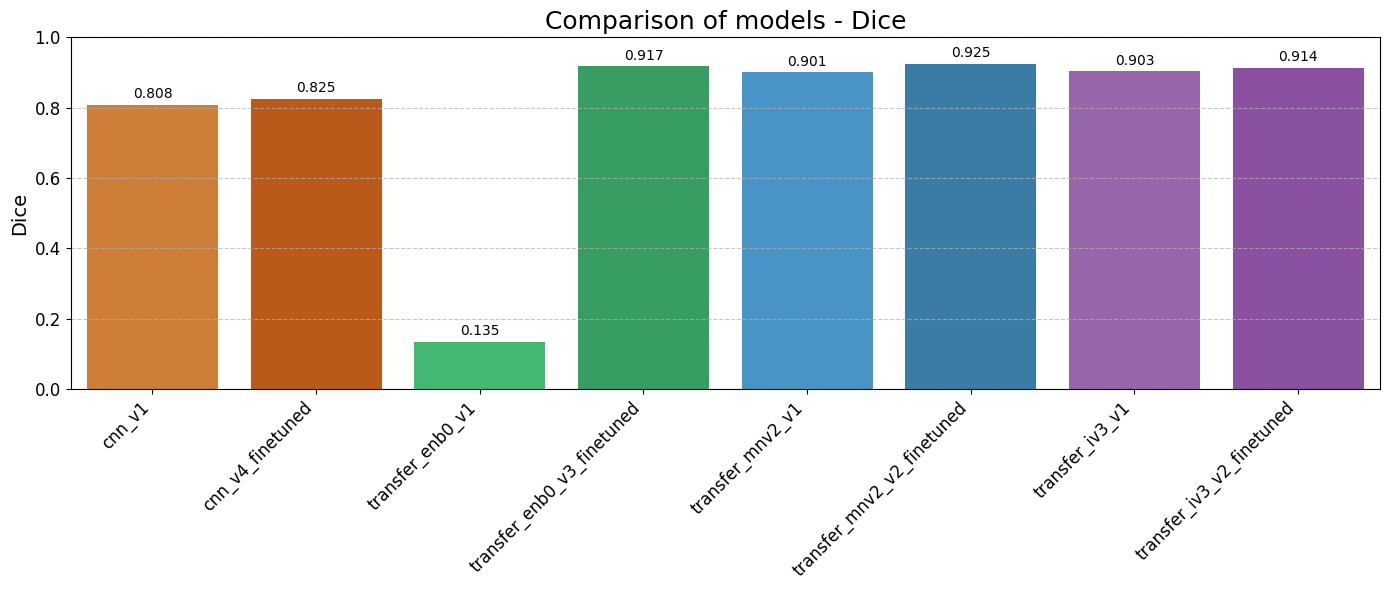

In [ ]:
results_df = pd.DataFrame(results)

metrics = ['Accuracy', 'Loss', 'Precision', 'Recall', 'F1-Score', 'IoU', 'Dice']

# kolory dla par modeli
palette = [
    '#e67e20', '#d35400',
    '#2ecc71', '#27ae60',
    '#3498db', '#2980b9',
    '#9b59b6', '#8e44ad'
]

model_colors = dict(zip(results_df['Model'], palette))

for metric in metrics:
    plt.figure(figsize=(14,6))
    ax = sns.barplot(
        x='Model',
        y=metric,
        data=results_df,
        palette=[model_colors[model] for model in results_df['Model']]
    )
    plt.title(f'Comparison of models - {metric}', fontsize=18)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    if metric != 'Loss':
        plt.ylim(0, 1)
    else:
        plt.ylim(0, results_df['Loss'].max() + 0.1)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlabel("")
    plt.ylabel(metric, fontsize=14)

    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.3f}',
            (p.get_x() + p.get_width() / 2., p.get_height() + 0.01),
            ha='center', va='bottom',
            fontsize=10, color='black'
        )

    plt.tight_layout()
    plt.show()

Podsumowując:

* najsłabszy model to `transfer_enb0_v1` — bez dostrajania,
* najlepsze wyniki osiągnęły modele po pełnym fine tuningu, zwłaszcza `transfer_mnv2_v2_finetuned` i `transfer_enb0_v3_finetuned`,
* własne modele `cnn_v1` i `cnn_v4_finetuned` były poprawne, ale wyraźnie słabsze od modeli transfer learningowych po dostosowaniu



---
Bardzo ważnym wnioskiem z tego zadania było uświadomienie sobie, jak duży wpływ na końcowe wyniki ma odpowiednie dostrajanie modeli transfer learningowych i jak znacząco można poprawić ich skuteczność dzięki pełnemu lub częściowemu fine tuningowi.

Ważnym elementem było także przekonanie się, że wyniki na zbiorze walidacyjnym nie zawsze przekładają się bezpośrednio na zbiorze testowym oraz jak kluczowe jest wykorzystanie różnych metryk (F1, IoU, Dice) do pełnej oceny modeli, nie ograniczając się tylko do samej dokładności.

Udało się osiągnąć bardzo wysoką skuteczność na zbiorze testowym, co potwierdza względną poprawność przyjętej metodologii pracy. Wyzwaniem było odpowiednie zarządzanie procesem fine tuningu i kontrola przeuczenia przy intensywnych zmianach architektur modeli, co pokazało, jak ważna jest cierpliwość i systematyczność w eksperymentowaniu.